# **Bank Marketing**

#### **Soure:** Dataset from https://archive.ics.uci.edu/dataset/222/bank+marketing

## **Importing libraries**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import FuncFormatter

/Users/fuenganh/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE, RandomOverSampler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, r2_score

In [3]:
import warnings
warnings.filterwarnings('ignore')








## **Functions**

In [4]:
def missing_values_table(df):

    """Function to calculate missing values by column."""

    # Total missing values
    miss_val = df.isnull().sum()

    # Percentage of missing values
    miss_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    miss_val_table = pd.concat([miss_val, miss_val_percent], axis=1)

    # Rename the columns
    miss_val_table_ren_columns = miss_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Sort the table by percentage of missing descending
    miss_val_table_ren_columns = miss_val_table_ren_columns[
        miss_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
           "There are " + str(miss_val_table_ren_columns.shape[0]) + " columns that have missing values.")

    # Return the dataframe with missing information
    return miss_val_table_ren_columns

In [5]:
def format_thousands(value, _):
    """
    Định dạng số hàng nghìn với dấu phẩy.
    """
    return "{:,.0f}".format(value)

In [6]:
def calculate_perc_categories(df, groupby_col, target_col):

    grouped_data = df.groupby(groupby_col + [target_col]).size().unstack(fill_value=0)
    percentage_data = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

    return percentage_data.round(2)

In [7]:
def plot_distribution(data, column, ax):
    colors = ['#dc143c', '#c4c4c4']

    # Pie chart
    labels = data[column].value_counts().index
    vals = data[column].value_counts().values

    ax[0].pie(vals,
              explode=[0, 0.2],
              labels=labels,
              colors=colors,
              autopct='%.2f%%',
              shadow=False,
              wedgeprops=dict(edgecolor='black'))

    # Chỉnh lại size của annotate
    for text in ax[0].texts:
        text.set_fontsize(12)

    ax[0].set_ylabel('')

    # Countplot
    bars = ax[1].bar(labels,
                    vals,
                    color=colors,
                    edgecolor='black')

    ax[1].set_xticks([0.00, 1.00])
    ax[1].set_yticks([])  # Xoá ytick
    ax[1].spines[['right', 'left', 'top']].set_visible(False)  # Xoá spine bên phải

    for bar in bars:
        count = bar.get_height()
        formatted_count = '{:,.0f}'.format(count)
        ax[1].annotate(f'{formatted_count}',
                       xy=(bar.get_x() + bar.get_width() / 2, count),
                       xytext=(0, 3),  # 3 points vertical offset
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=12, color='black')

    # Chỉnh size của xtick
    ax[0].tick_params(axis='x', labelsize=16)
    ax[1].tick_params(axis='x', labelsize=16)

    # Chỉnh khoảng cách giữa 2 ax
    plt.subplots_adjust(wspace=0.8)

    # Show the plot
    plt.suptitle(f'Distribution of {column} value', fontsize=23, color='black')

In [8]:
def plot_categorical_bar_vertical(data, column_name, figsize=(10, 6), percentage_display=True, rotation=0, vertical_adjust=300, fontsize_percent=11):

    print(f"Total number of unique categories in '{column_name}': {len(data[column_name].unique())}")

    plt.figure(figsize=figsize)
    sns.set(style='whitegrid', font_scale=1.2)

    data_to_plot = data[column_name].value_counts().sort_values(ascending=False)
    ax = sns.barplot(x=data_to_plot.index, y=data_to_plot.values, palette=sns.color_palette('Paired'))

    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            ax.text(p.get_x() + p.get_width() / 2,
                    p.get_height() + vertical_adjust,
                    '{:1.02f}%'.format(p.get_height() * 100 / total_datapoints),
                    fontsize=fontsize_percent,
                    ha='center')

    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation)
    ax.grid(False)

    ax.tick_params(axis='x', labelsize=11)
    ax.tick_params(axis='y', labelsize=11)

    plt.title(f'{column_name} count distribution', pad=20)
    plt.tight_layout(pad=0.5)
    plt.show()

In [9]:
def plot_categorical_bar_vertical_with_class_sorted(data, column_name, class_column='y', figsize=(10, 6), percentage_display=True, rotation=0, fontsize_percent=11):

    print(f"Total number of unique categories in '{column_name}': {len(data[column_name].unique())}")

    plt.figure(figsize=figsize)
    sns.set(style='whitegrid', font_scale=1.2)

    # Đếm số lượng từng nhóm theo class (yes/no) và sắp xếp theo tổng số lượng
    data_to_plot = data.groupby([column_name, class_column]).size().unstack(fill_value=0)
    data_to_plot["Total"] = data_to_plot.sum(axis=1)  # Thêm cột tổng số lượng

    # Vẽ biểu đồ stacked bar chart
    ax = data_to_plot.drop(columns=["Total"]).plot(kind='bar', stacked=True, figsize=figsize, color=['#b0b0b0', '#c44e52'])

    # Cấu hình trục và giao diện
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation)

    ax.tick_params(axis='x', labelsize=11)
    ax.tick_params(axis='y', labelsize=11)
    ax.grid(False, which='both')

    plt.title(f'{column_name} count distribution by class ({class_column})', pad=20)
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.legend(title=class_column, labels=['No', 'Yes'])

    plt.tight_layout(pad=0.5)
    plt.show()

In [10]:
def plot_categorical_by_target(data, column, target='y', figsize=(12, 6), rotation=30):
    # Đảm bảo kiểu dữ liệu là string
    data[column] = data[column].astype(str)
    data[target] = data[target].astype(str)

    # Xác định thứ tự theo tần suất giảm dần
    order = data[column].value_counts().index

    # Tạo biểu đồ
    plt.figure(figsize=figsize)
    sns.set(style='whitegrid', font_scale=1.1)

    sns.countplot(data=data, x=column, hue=target, order=order, palette='Paired')
    plt.title(f'{column.capitalize()} vs. Term Deposit Subcription (y)', fontsize=14, pad=15)
    plt.xlabel(column.capitalize(), fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=rotation, ha='right')
    plt.tight_layout()
    plt.show()

In [11]:
def stats_col(data, job_column='job', class_column='y'):
    # Đếm số lượng theo nghề và class
    counts = data.groupby([job_column, class_column]).size().unstack(fill_value=0)

    # Tính tổng số dòng cho từng nghề nghiệp
    counts['Row Total'] = counts.sum(axis=1)

    # Tính tỷ lệ phần trăm trên tổng số dòng cho từng nghề nghiệp
    percentages = counts.div(counts['Row Total'], axis=0).round(2)

    # Thêm nhãn cho từng dòng (Count/Percentage)
    counts['Type'] = 'Count'
    percentages['Type'] = 'Percentage'

    # Kết hợp số lượng và phần trăm vào cùng một bảng
    combined = pd.concat([counts, percentages])

    # Sắp xếp để dòng % nằm ngay dưới dòng số lượng
    combined = combined.sort_index(level=0).reset_index()

    # Đặt cột 'Type' làm chỉ mục thứ hai để hiển thị rõ ràng
    combined = combined.set_index([job_column, 'Type'])

    # Xoá cột 'Row Total (%)' để giữ cấu trúc giống bảng gốc
    combined = combined.drop(columns=['Row Total']) if 'Row Total' in combined.columns else combined

    return combined

## **Dataset view**

In [12]:
bank = pd.read_csv("/Users/fuenganh/Desktop/bank-additional-full.csv", sep=";")
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [13]:
bank['previous'].value_counts()

previous
0    35563
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: count, dtype: int64

## **Dataset information**

In [14]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [15]:
bank['y'] = bank['y'].map({'yes': 1, 'no': 0})

### **1. Checking for unique values in all attributes**

In [16]:
bank.nunique().sort_values(ascending=True)

y                    2
contact              2
default              3
housing              3
loan                 3
poutcome             3
marital              4
day_of_week          5
education            8
previous             8
emp.var.rate        10
month               10
nr.employed         11
job                 12
cons.price.idx      26
cons.conf.idx       26
pdays               27
campaign            42
age                 78
euribor3m          316
duration          1544
dtype: int64

### **2. Checking for missing values in each column**
- No missing values in our dataset

In [17]:
bank.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [18]:
table_miss_val = missing_values_table(bank)
table_miss_val

Your selected dataframe has 21 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [19]:
bank['pdays'].value_counts()

pdays
999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
22         3
19         3
21         2
25         1
26         1
27         1
20         1
Name: count, dtype: int64

<u>_Nhận xét:_</u>  
- Dữ liệu không có missing values


### **3. Check duplicate**

In [20]:
bank.duplicated().sum()

12

- Confirm lại các rows bị duplicated trước khi remove chúng

In [21]:
bank.loc[bank.duplicated(keep=False)]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1265,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,0
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,0
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0
16819,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0
18464,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,0
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,0


In [22]:
bank = bank.drop_duplicates()

In [23]:
bank.duplicated().sum()

0

### **4. Numerical (discrete, continuous) features descriptive statistics**

In [24]:
# categorical columns
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan',
                       'contact', 'month', 'day_of_week', 'poutcome', 'y']

# numerical columns
numerical_columns = ['age', 'duration', 'campaign', 'pdays', 'previous',
                     'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                     'euribor3m', 'nr.employed']

In [25]:
bank.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870,0.112663
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364,0.316184
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


In [26]:
for col in categorical_columns:
    print(f"{col}: {bank[col].unique()}\n")

job: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']

marital: ['married' 'single' 'divorced' 'unknown']

education: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']

default: ['no' 'unknown' 'yes']

housing: ['no' 'yes' 'unknown']

loan: ['no' 'yes' 'unknown']

contact: ['telephone' 'cellular']

month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']

day_of_week: ['mon' 'tue' 'wed' 'thu' 'fri']

poutcome: ['nonexistent' 'failure' 'success']

y: [0 1]



<u>_Phân tích:_</u>  

**Sau khi đánh giá các thống kê mô tả của dữ liệu dạng số và các unique value của dữ liệu dạng categorical, ta thấy:**
- Phần lớn các biến số học có xu hướng **lệch phải**, thể hiện qua sự chênh lệch đáng kể giữa giá trị trung vị và Q3 (khoảng phân vị thứ 3).

- Nhiều biến phân loại chứa giá trị **unknown**: 'job', 'marital', 'education', 'default', 'housing', 'loan'.

- Một số biến dạng thời gian cũng bị thiếu dữ liệu, chẳng hạn như biến **month** không có dữ liệu của tháng 1 (**January**) và tháng 2 (**February**).

- Biến **day_of_week** thì thiếu dữ liệu những ngày cuối tuần **Saturday** & **Sunday**. Tuy nhiên, có thể suy luận rằng do đây là dữ liệu hoạt động telemarketing, nên những ngày cuối tuần là thời gian nghỉ của tổng đài viên, điều này có thể giải thích hợp lý cho việc không có dữ liệu vào thứ 7 và Chủ nhật.

- Đối với các biến phân loại, cần EDA thêm để xác định cách xử lý các giá trị **unknown**.


## **Data exploration & visualization**

### **1. Bank Client data analysis**
- Work with the attributes related to bank clients

#### **1.1. AGE column**

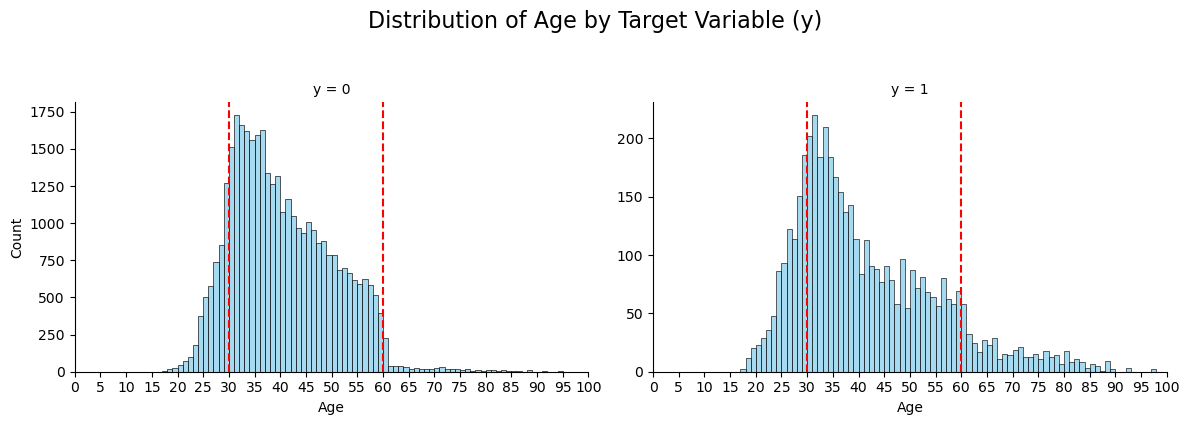

In [27]:
g = sns.FacetGrid(bank, col="y", sharey=False, height=4, aspect=1.5)
g.map_dataframe(sns.histplot, x='age', binwidth=1, color='skyblue')

for ax in g.axes.flat:
    ax.axvline(x=30, color='red', linestyle='dashed')
    ax.axvline(x=60, color='red', linestyle='dashed')

    ax.set_xticks(range(0, 101, 5))
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

g.set(xlim=(0, 100))
g.set_axis_labels("Age", "Count")
g.fig.suptitle('Distribution of Age by Target Variable (y)', fontsize=16, y=1.05)

plt.tight_layout()
plt.show()

<u>_Phân tích:_</u>  

**A. Biểu đồ bên trái (y = 0 – Không đăng ký tiền gửi):**
- Độ tuổi tập trung nhiều nhất ở khoảng 30 đến 40 tuổi.
- Sau 60 tuổi: Số lượng khách hàng không đăng ký giảm mạnh sau 60 tuổi.
- Ngân hàng chủ yếu liên hệ với khách hàng trong độ tuổi trung niên nhưng phần lớn từ chối mở tài khoản tiền gửi có kỳ hạn.

**B. Biểu đồ bên phải (y = 1 – Đăng ký tiền gửi):**
- Dù số lượng khách hàng đăng ký ít hơn, nhưng biểu đồ cho thấy phân phối đồng đều hơn so với nhóm không đăng ký.
- Sau 60 tuổi: Sau ngưỡng 60 tuổi, số lượng khách hàng đồng ý đăng ký tiền gửi không giảm mạnh như nhóm y = 0. Thậm chí, tỷ lệ khách hàng lớn tuổi đồng ý đăng ký cao hơn so với các nhóm tuổi khác.
- Người lớn tuổi (trên 60 tuổi) có khả năng cao hơn trong việc đăng ký tiền gửi.
Dù ngân hàng không tập trung nhiều vào nhóm lớn tuổi, nhưng nhóm này lại có tỷ lệ chuyển đổi cao.

#### **1.2. JOB column**

Total number of unique categories in 'job': 12


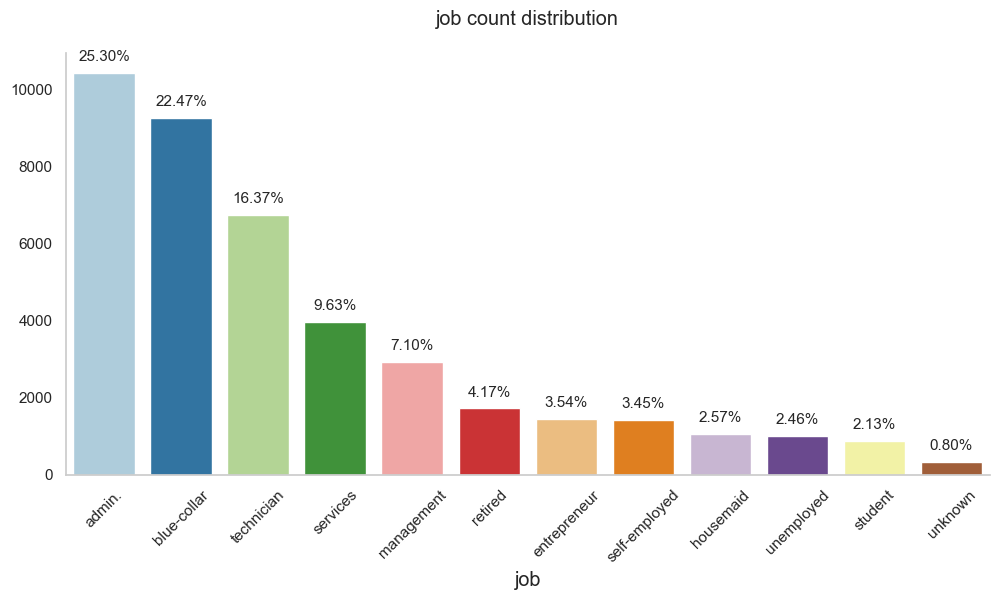

In [28]:
plot_categorical_bar_vertical(bank, 'job', rotation=45)

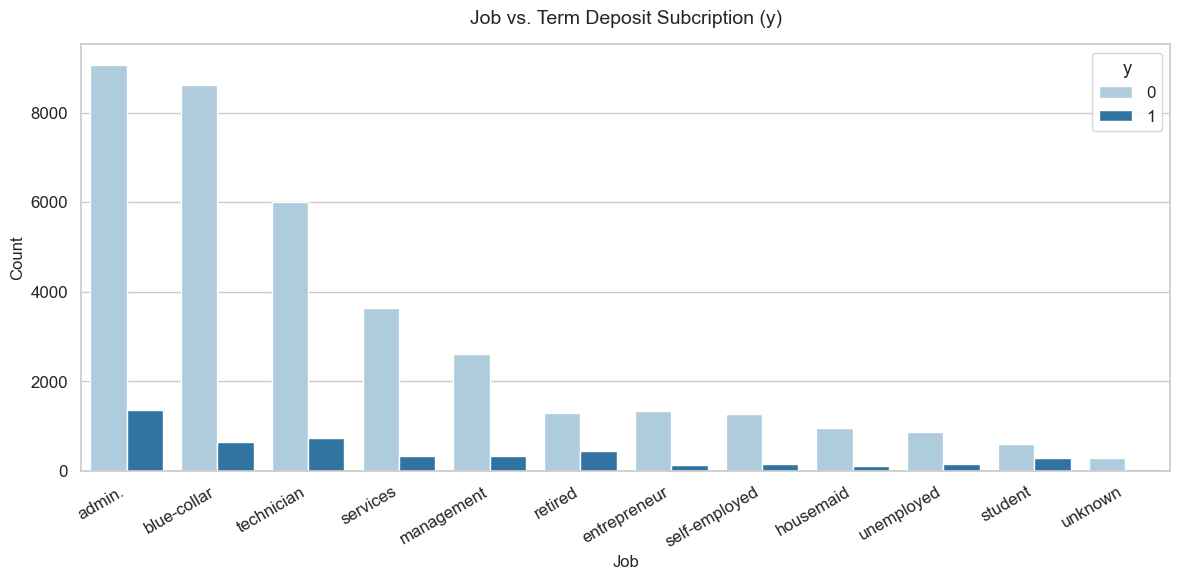

In [29]:
plot_categorical_by_target(bank, "job")

<u>_Phân tích:_</u>  

**Nhóm nghề nghiệp có tỷ lệ đăng ký thành công cao nhất:**
- Các nhóm "admin.", "blue-collar" và "technician" maybe sẽ có xác suất đăng ký tiền gửi kỳ hạn cao nhất. Nếu ngân hàng muốn tối ưu hóa chiến dịch tiếp thị, thì các nhóm này có thể là đối tượng mục tiêu phù hợp nhất.

**Nhóm nghề nghiệp có tỷ lệ thành công thấp nhất:**
- Các nhóm "student", "unemployed" và "housemaid" có tỷ lệ đăng ký thấp.
- Điều này cho thấy họ có thể không quan tâm nhiều đến tiền gửi kỳ hạn hoặc có nhu cầu tài chính khác. Ngân hàng có thể cần chiến lược tiếp thị khác biệt hoặc các sản phẩm phù hợp hơn cho các nhóm này.

#### **1.3. MARITAL column**

Total number of unique categories in 'marital': 4


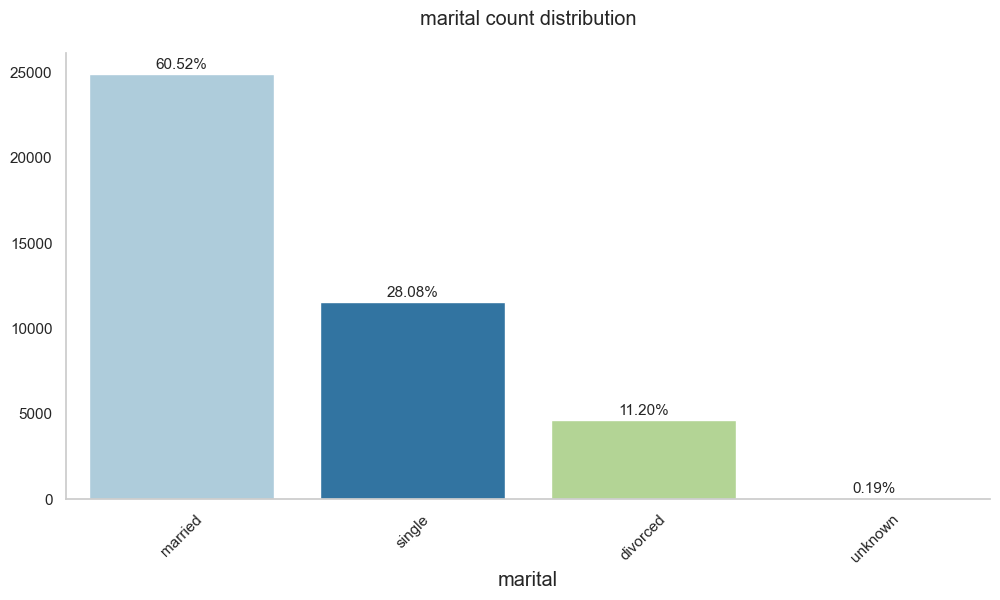

In [30]:
plot_categorical_bar_vertical(bank, 'marital', rotation=45)

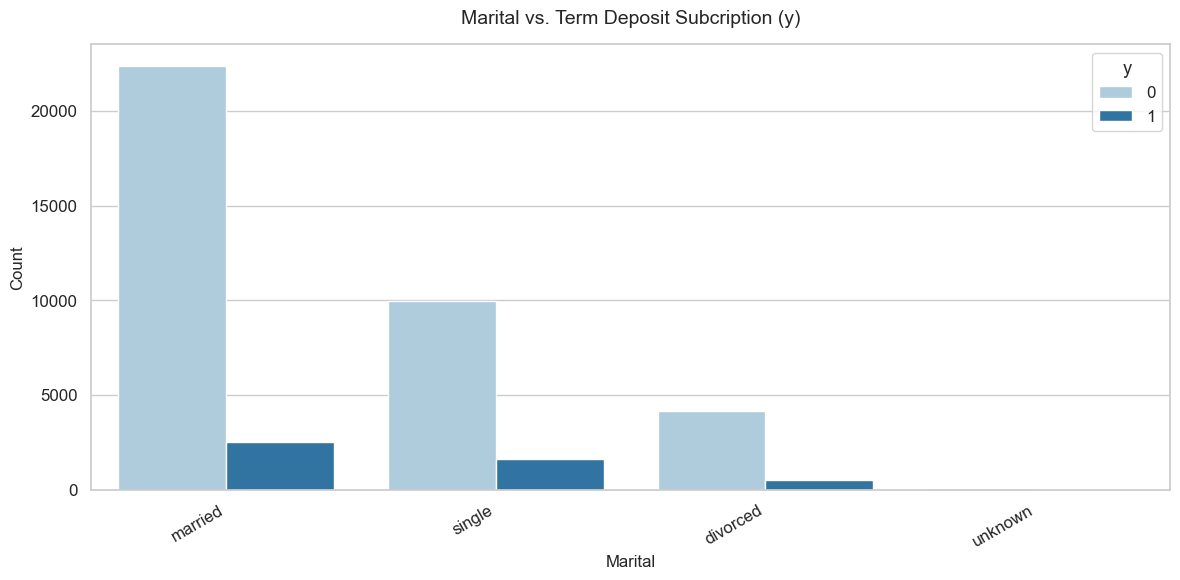

In [31]:
plot_categorical_by_target(bank, "marital")

<u>_Phân tích:_</u>  

**Nhóm "married" có tỷ lệ đăng ký tiền gửi cao nhất:**
- Các nhóm "single" và "divorced" chiếm tỷ lệ nhỏ hơn.
- Có thể ảnh hưởng đến hành vi tiết kiệm, vì người đã lập gia đình maybe sẽ có xu hướng tài chính ổn định hơn.

#### **1.4. EDUCATION column**

Total number of unique categories in 'education': 8


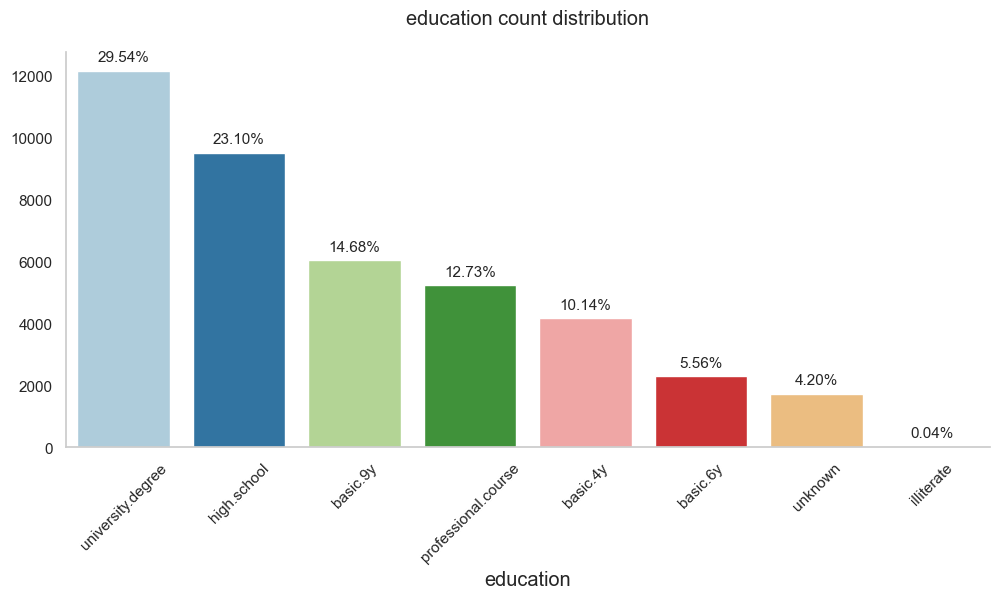

In [32]:
plot_categorical_bar_vertical(bank, 'education', rotation=45)

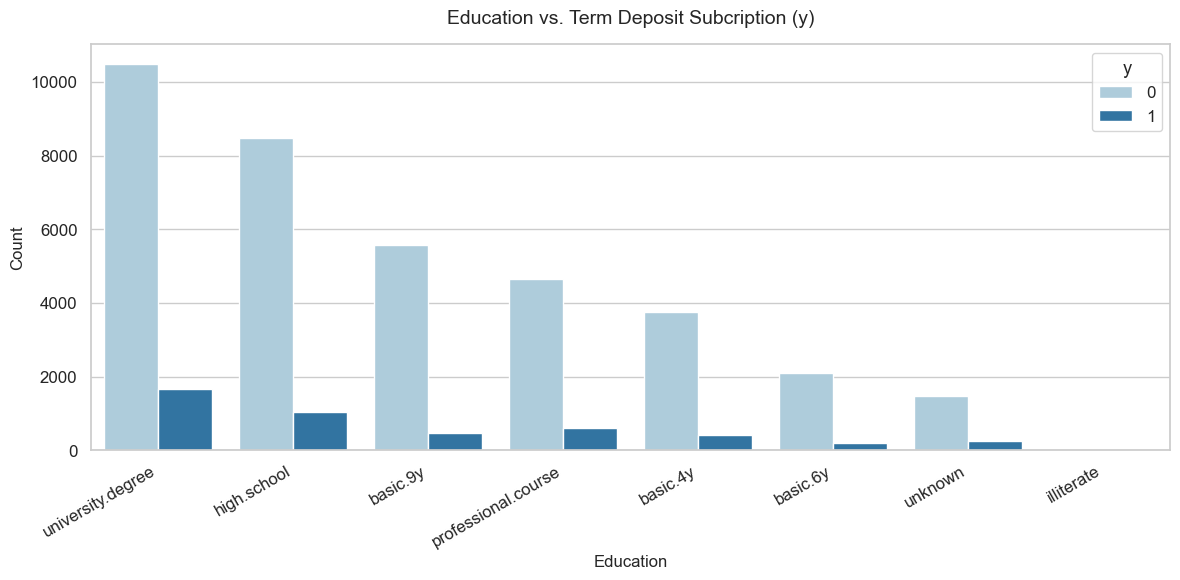

In [33]:
plot_categorical_by_target(bank, "education")

<u>_Phân tích:_</u>  

**Nhóm có trình độ học vấn cao có tỷ lệ đăng ký tiền gửi cao nhất:**
- Những người có bằng đại học trở lên có khả năng đăng ký tiền gửi kỳ hạn cao nhất.
- Điều này có thể cho thấy rằng nhóm này dễ tiếp nhận các sản phẩm/dịch vụ tài chính hơn.Họ có thể có hiểu biết tốt hơn về tài chính hoặc có thu nhập ổn định hơn, giúp họ dễ dàng ra quyết định gửi tiền.

**Nhóm có trình độ học vấn thấp có tỷ lệ thành công thấp:**
- Những người mù chữ (illiterate) hoặc chỉ có trình độ học vấn cơ bản (basic education) có tỷ lệ đăng ký rất thấp.
- Nhóm này có thể ít hiểu biết về tài chính, hoặc có thu nhập thấp, khiến họ không quan tâm đến tiền gửi kỳ hạn.

#### **1.5. DEFAULT, HOUSING, LOAN column**

Total number of unique categories in 'default': 3


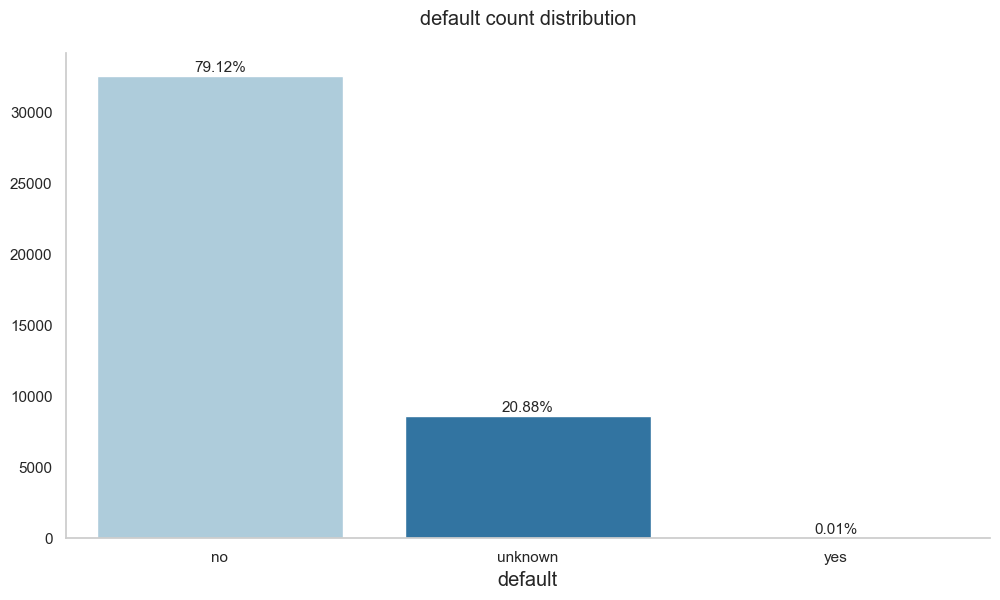

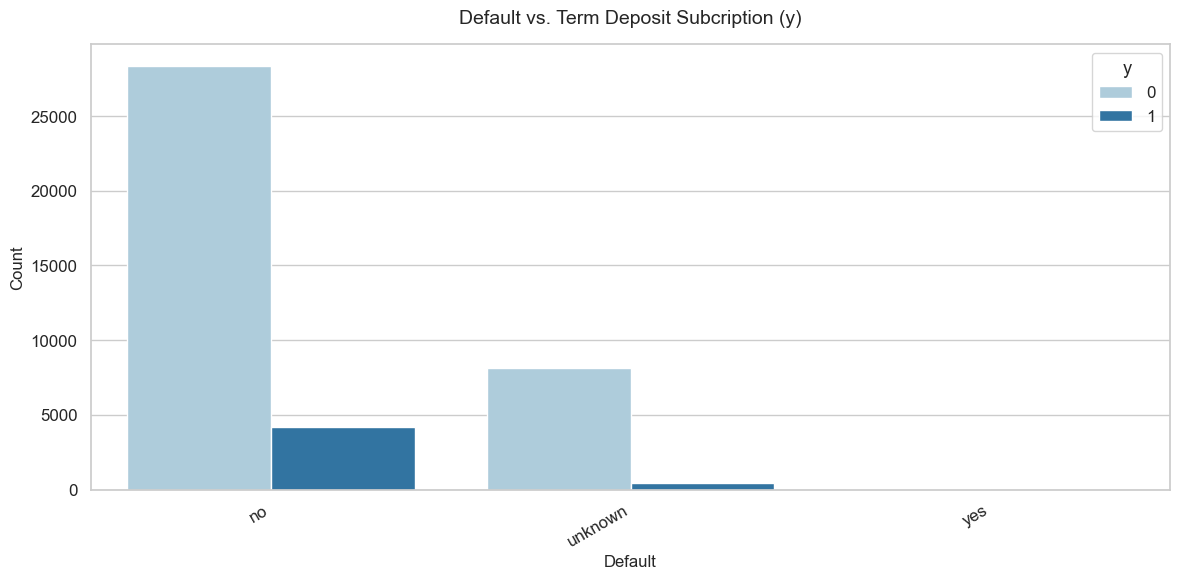

In [34]:
plot_categorical_bar_vertical(bank, 'default', rotation=0)
plot_categorical_by_target(bank, "default")

Total number of unique categories in 'housing': 3


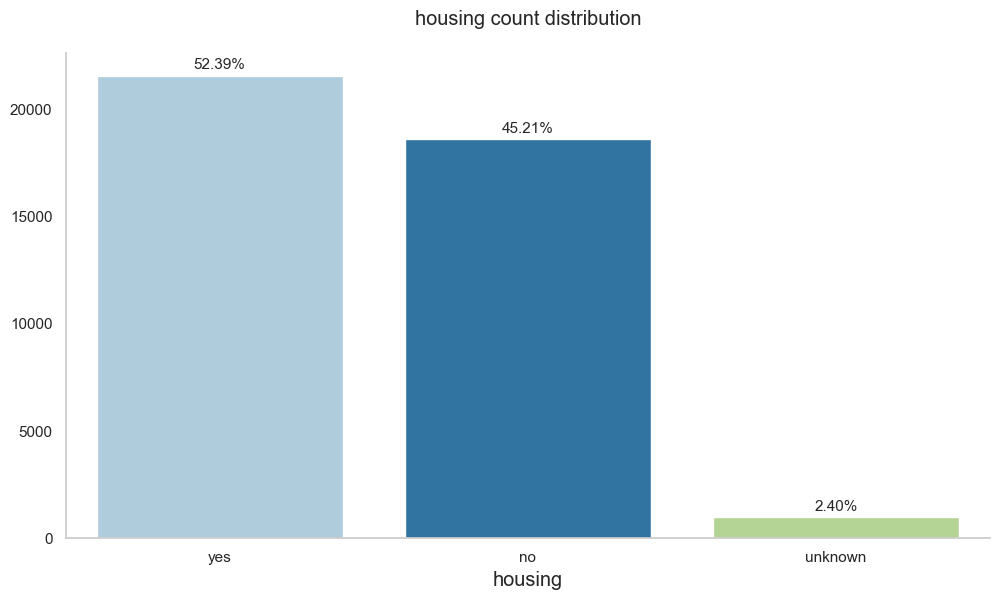

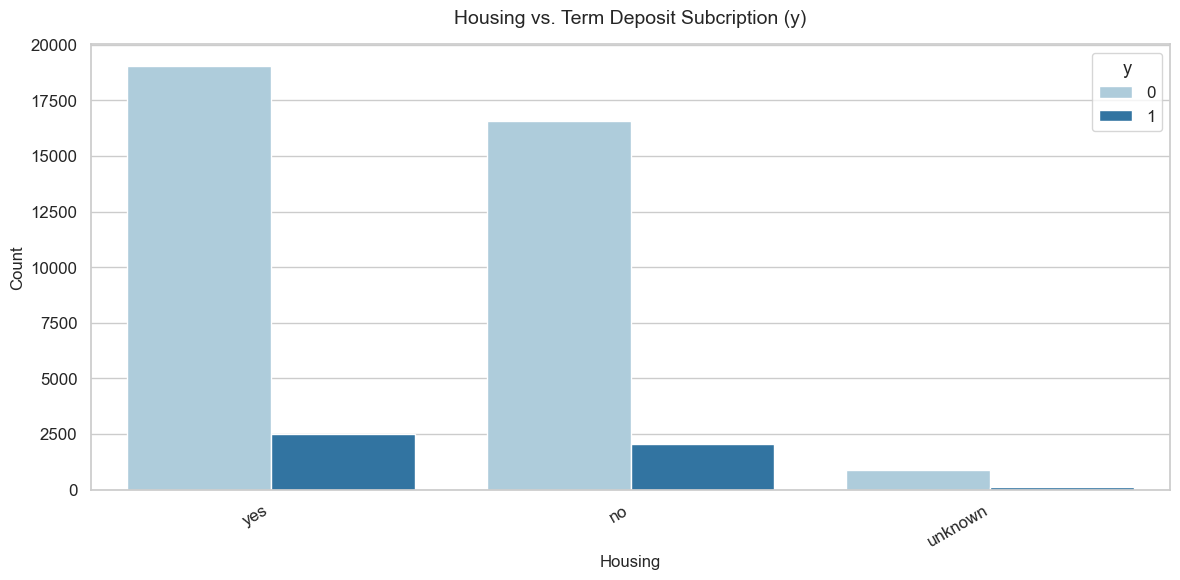

In [35]:
plot_categorical_bar_vertical(bank, 'housing', rotation=0)
plot_categorical_by_target(bank, "housing")

Total number of unique categories in 'loan': 3


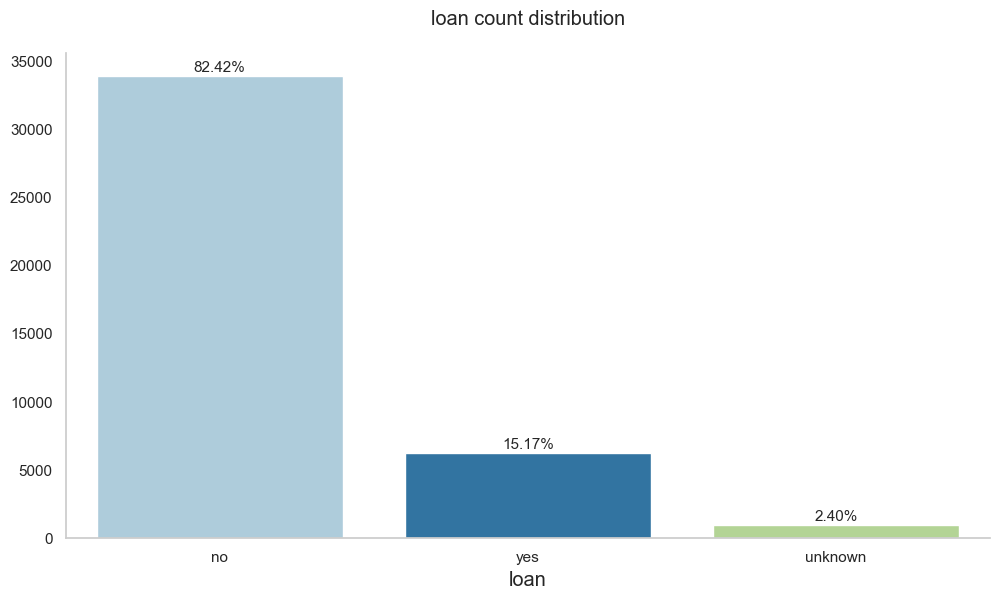

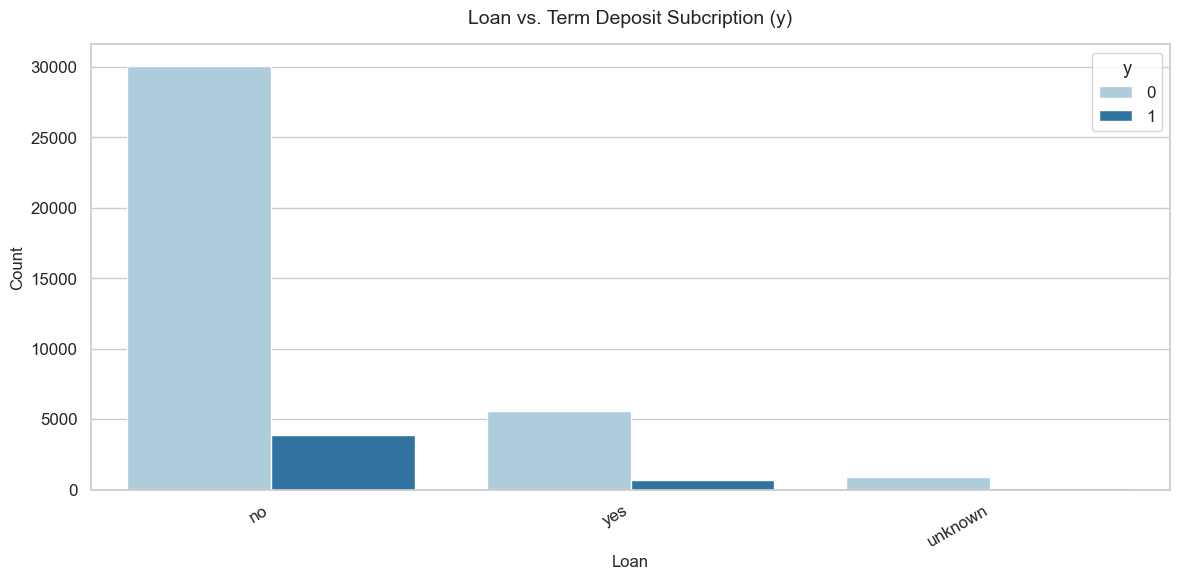

In [36]:
plot_categorical_bar_vertical(bank, 'loan', rotation=0)
plot_categorical_by_target(bank, "loan")

### **2. Current campaign data analysis**
- Explore categorical, see those values

#### **2.1. DURATION column**

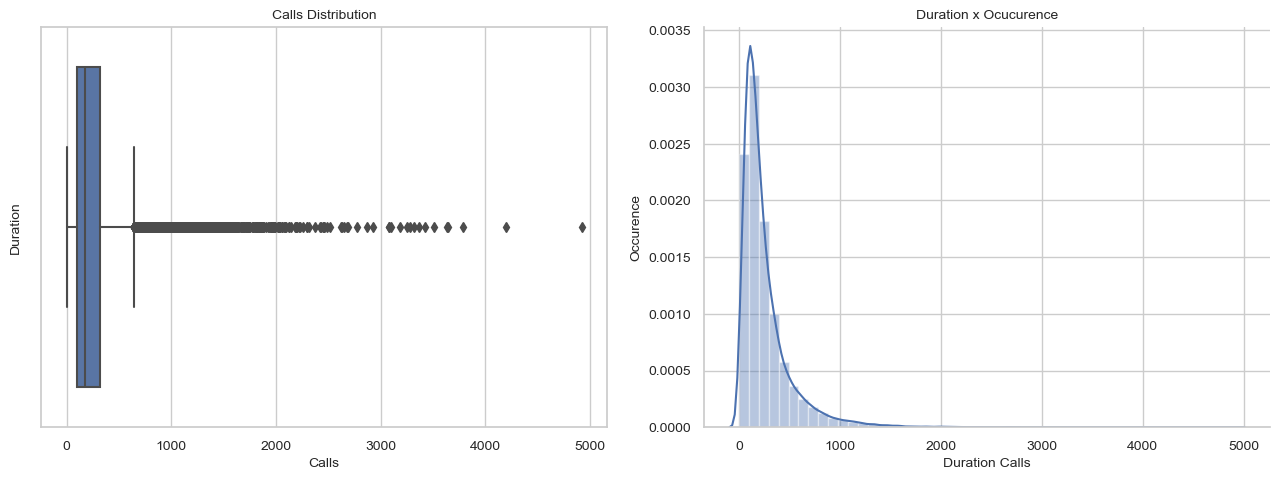

In [37]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
sns.boxplot(x = 'duration', data = bank, orient = 'v', ax = ax1)
ax1.set_xlabel('Calls', fontsize=10)
ax1.set_ylabel('Duration', fontsize=10)
ax1.set_title('Calls Distribution', fontsize=10)
ax1.tick_params(labelsize=10)

sns.distplot(bank['duration'], ax = ax2)
sns.despine(ax = ax2)
ax2.set_xlabel('Duration Calls', fontsize=10)
ax2.set_ylabel('Occurence', fontsize=10)
ax2.set_title('Duration x Ocucurence', fontsize=10)
ax2.tick_params(labelsize=10)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()

#### **2.2. CONTACT column**

Total number of unique categories in 'contact': 2


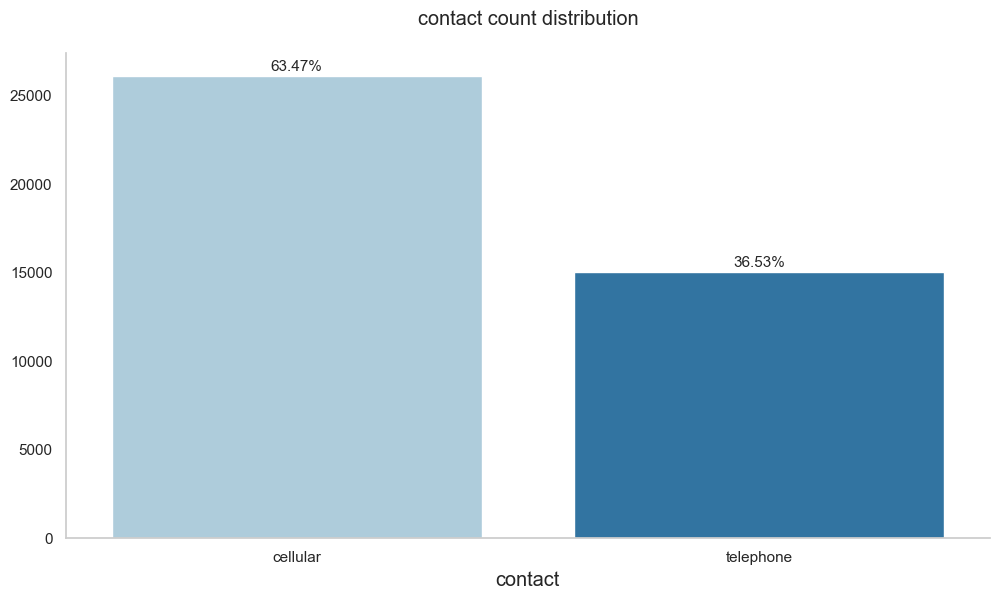

In [38]:
plot_categorical_bar_vertical(bank, 'contact', rotation=0)

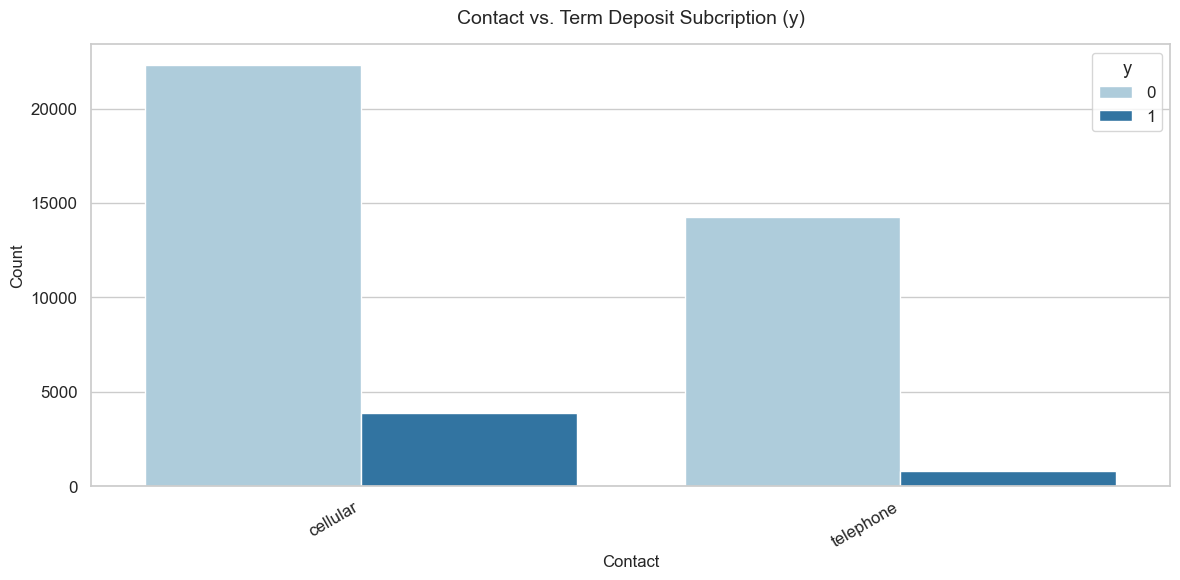

In [39]:
plot_categorical_by_target(bank, "contact")

<u>_Phân tích:_</u>  

**Số lượng cuộc gọi qua di động (cellular) cao hơn đáng kể:**
- Cho thấy sự phổ biến của điện thoại di động trong xã hội hiện đại.

**Trong cả hai phương thức liên hệ, số lượng khách hàng không đăng ký áp đảo, tuy nhiên:**
- Tỷ lệ khách hàng đăng ký qua **celular** cao hơn rõ rệt so với qua **telephone**
- Nhóm **telephone** có số lượng khách hàng đăng ký rất nhỏ, thể hiện hiệu quả tiếp thị thấp hơn.

#### **2.3. MONTH column**

Total number of unique categories in 'month': 10


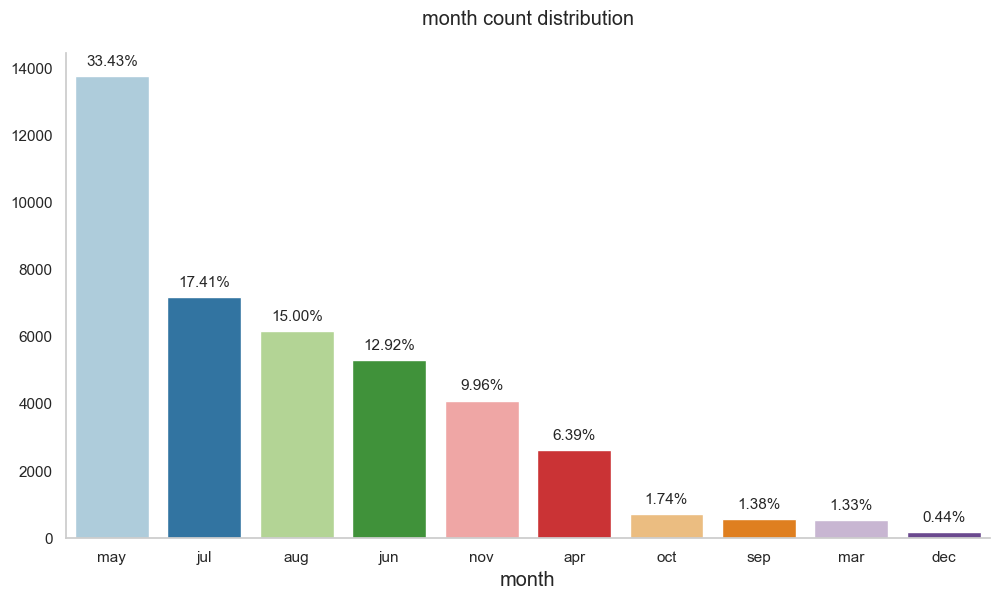

In [40]:
plot_categorical_bar_vertical(bank, 'month', rotation=0)

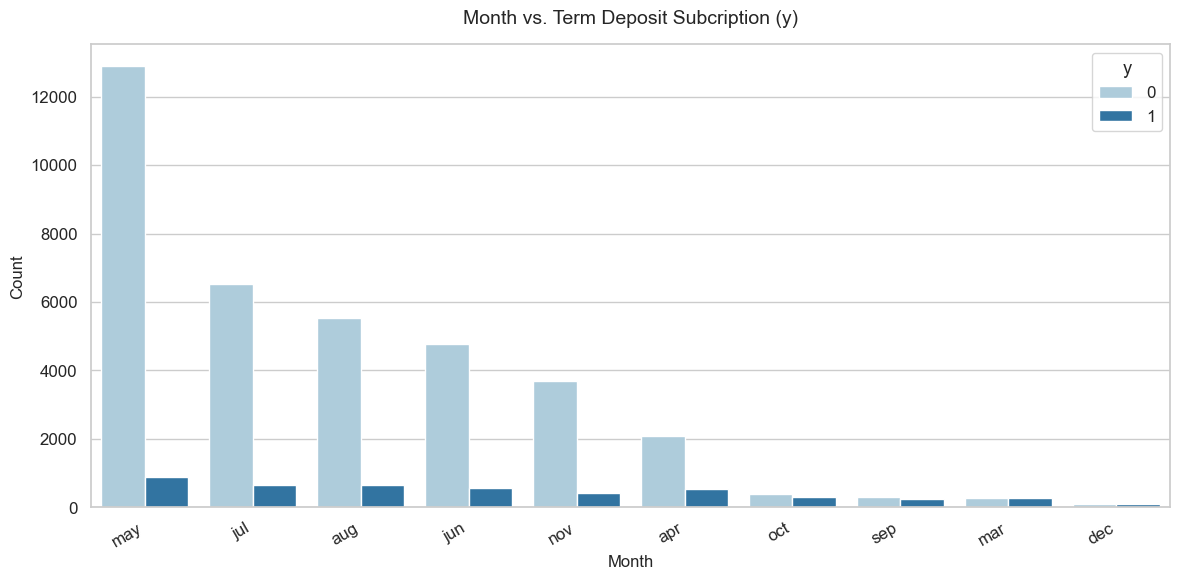

In [41]:
plot_categorical_by_target(bank, "month")

<u>_Phân tích:_</u>  

- Dữ liệu tập trung chủ yếu vào các tháng: **Tháng 5 (May: 33.4%)**, **tháng 7 (July: 17.4%**, **tháng 8 (August: 15%)**, **tháng 6 (June: 12.9%)**. Maybe đây là các tháng cao điểm của chiến dịch telemarketing.

**Không có dữ liệu cho tháng 1 và tháng 2.**
- Cần lưu ý khi train model.

**Month vs. Term deposit subscription (y):**
- Mặc dù tháng 5 có số lượng liên hệ cao nhất, nhưng tỷ lệ đăng ký (y=1) trong tháng này lại khá thấp so với số cuộc gọi => hiệu quả thấp.
- Các tháng có tỷ lệ đăng ký tốt hơn (dù số lượng liên hệ ít): **Tháng 3, 9, 12** => cột y=1 gần bằng hoặc vượt y=0
=> Những tháng ít cuộc gọi lại có tỷ lệ chuyển đổi cao, có thể do khách hàng ít bị làm phiền hoặc có nhu cầu thực sự.

#### **2.4. DAY_OF_WEEK column**

Total number of unique categories in 'day_of_week': 5


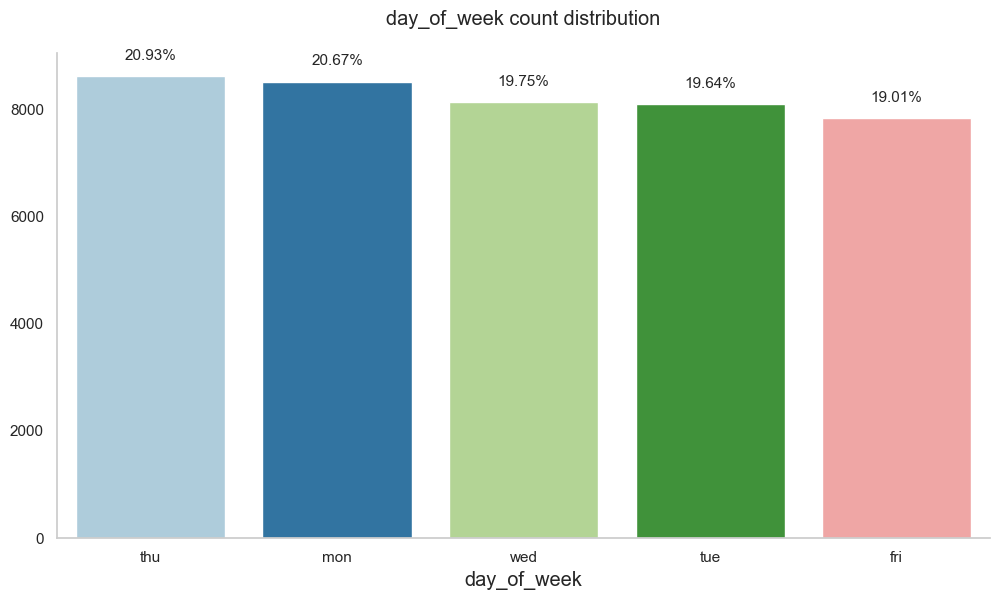

In [42]:
plot_categorical_bar_vertical(bank, 'day_of_week', rotation=0)

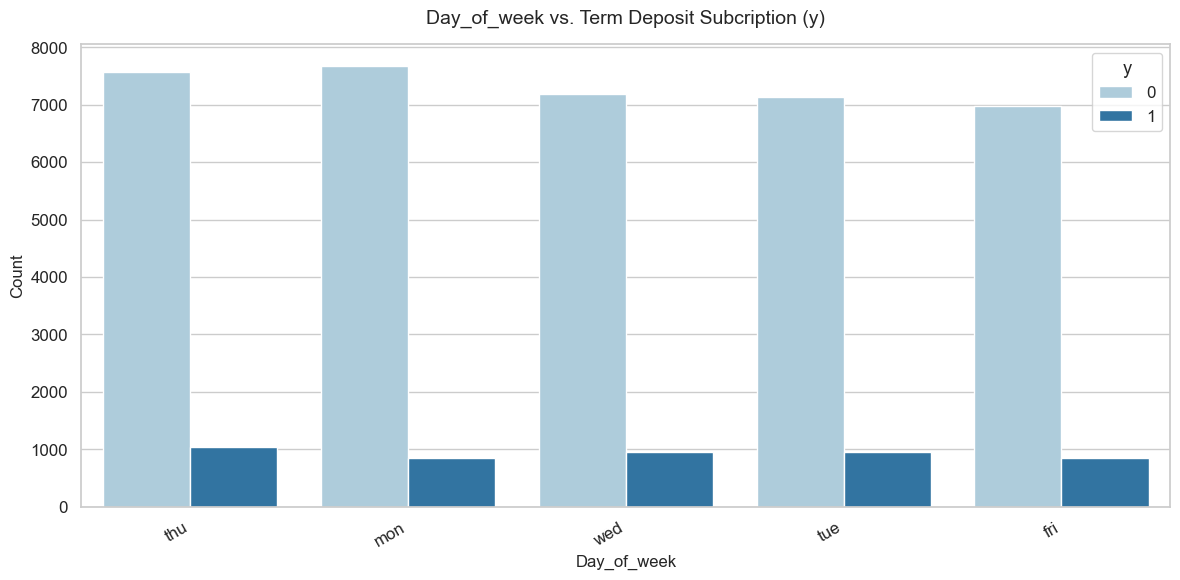

In [43]:
plot_categorical_by_target(bank, "day_of_week")

<u>_Phân tích:_</u>  

- Dữ liệu phân bố tương đối đồng đều giữa các ngày từ thứ 2 (monday) đến thứ 6 (friday), dao động từ 19% - 21%.
- Không có dữ liệu cuối tuần (saturday & sunday), hợp lý vì telemarketing thường không diễn ra vào cuối tuần.

**Số lượng khách hàng không đăng ký (y=0) vượt trội ở tất cả các ngày.**

**Tỷ lệ đăng ký (y=1) có vẻ khá đồng đều giữa các ngày, với sự chênh lệch không đáng kể:**
- Thứ 5 có số lượng đăng ký cao nhất, nhưng điều này phản ánh số cuộc gọi cao hơn chứ không nhất thiết do hiệu quả cao hơn.
- Không có ngày nào thực sự nổi bật về tỷ lệ chuyển đổi.

### **3. Previous campaign data analysis**


#### **3.1. CAMPAIGN column**

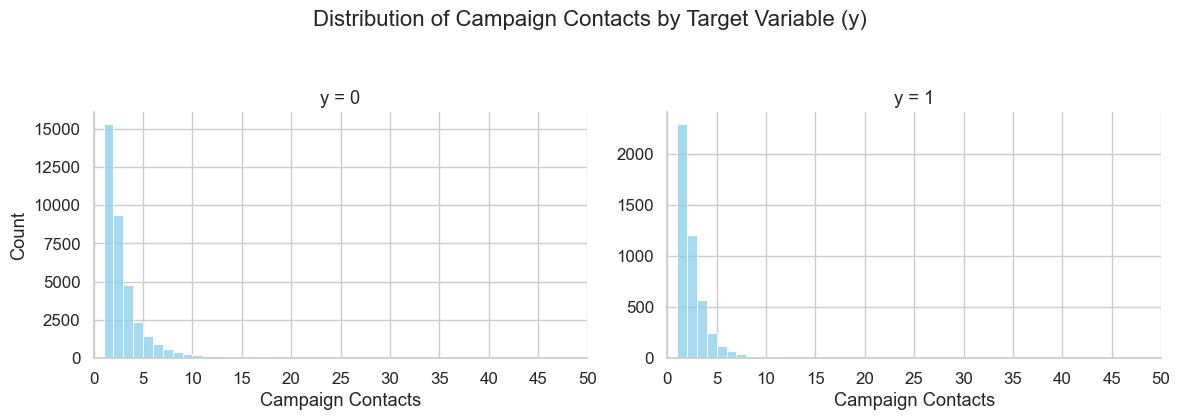

In [44]:
g = sns.FacetGrid(bank, col="y", sharey=False, height=4, aspect=1.5)
g.map_dataframe(sns.histplot, x='campaign', binwidth=1, color='skyblue')

for ax in g.axes.flat:
    ax.set_xticks(range(0, 51, 5))
    ax.set_xlim(0, 50)

g.set_axis_labels("Campaign Contacts", "Count")
g.fig.suptitle('Distribution of Campaign Contacts by Target Variable (y)', fontsize=16, y=1.05)

plt.tight_layout()
plt.show()

#### **3.2. PREVIOUS column**

In [45]:
bank['previous'].value_counts()

previous
0    35551
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: count, dtype: int64

- "previous": số cuộc gọi đã thực hiện trước chiến dịch này => lịch sử liên hệ của khách hàng

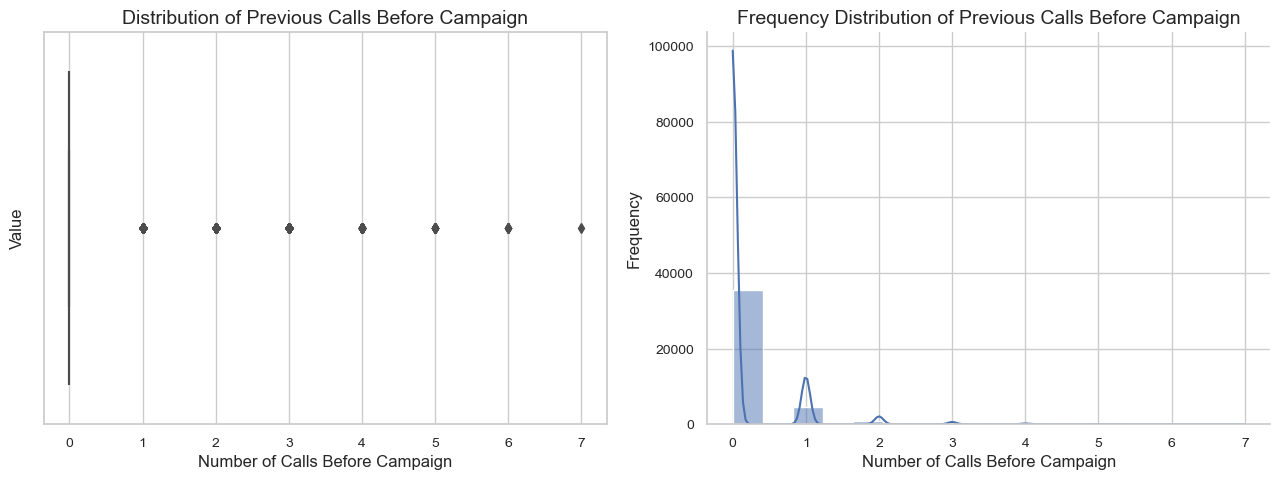

In [46]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

sns.boxplot(x='previous', data=bank, orient='v', ax=ax1)
ax1.set_xlabel('Number of Calls Before Campaign', fontsize=12)  
ax1.set_ylabel('Value', fontsize=12)  
ax1.set_title('Distribution of Previous Calls Before Campaign', fontsize=14)  
ax1.tick_params(labelsize=10)  

sns.histplot(bank['previous'], kde=True, ax=ax2)
sns.despine(ax=ax2)
ax2.set_xlabel('Number of Calls Before Campaign', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)  
ax2.set_title('Frequency Distribution of Previous Calls Before Campaign', fontsize=14)  
ax2.tick_params(labelsize=10)  

plt.subplots_adjust(wspace=0.5) 
plt.tight_layout()  
plt.show()


In [47]:
# Kiểm tra số lượng "yes" và "no" cho mỗi giá trị unique của 'previous'
df_grouped = bank.groupby('previous')['y'].value_counts().unstack(fill_value=0)
print(df_grouped)

y             0     1
previous             
0         32411  3140
1          3594   967
2           404   350
3            88   128
4            32    38
5             5    13
6             2     3
7             1     0


In [48]:
#convert all the values above 2 in previous to 2
bank["previous"] = bank["previous"].apply(lambda x: 2 if x >= 2 else x)

In [49]:
bank["previous"].value_counts()

previous
0    35551
1     4561
2     1064
Name: count, dtype: int64

In [50]:
# Kiểm tra số lượng "yes" và "no" cho mỗi giá trị unique của 'previous'
df_grouped = bank.groupby('previous')['y'].value_counts().unstack(fill_value=0)
print(df_grouped)


y             0     1
previous             
0         32411  3140
1          3594   967
2           532   532


### **4. Social & economic context attributes**

#### **4.1. EMP.VAR.RATE column**
- Tỷ lệ biến động việc làm (chỉ số hàng quý)

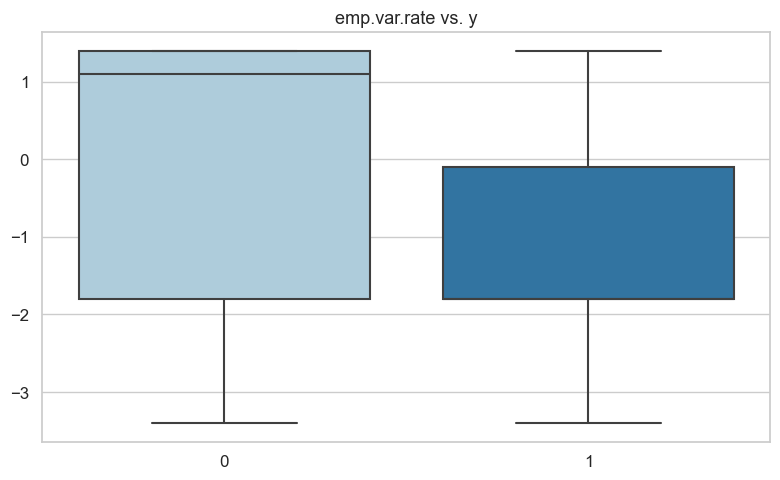

In [51]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=bank, x='y', y='emp.var.rate', palette='Paired')
plt.title('emp.var.rate vs. y', fontsize=13)
plt.xlabel(None)
plt.ylabel(None)
plt.tight_layout()
plt.show()

<u>_Phân tích:_</u>  

**Nhóm y=0 (không đăng ký):**
- Có median (trung vị) > 1, tức là phần lớn khách hàng không đăng ký khi tỷ lệ việc làm tăng cao.

**Nhóm y=1 (đăng ký):**
- Median nằm thấp hơn rõ rệt, gần mức 0, tức là khách hàng đăng ký chủ yếu trong điều kiện tỷ lệ việc làm thấp hoặc đang giảm.

**Giả thuyết ban đầu đặt ra:**
- Khi tỷ lệ việc làm tăng cao, khách hàng có nhiều tự tin tài chính hơn và sẽ sẵn sàng đầu tư - ví dụ như gửi tiền kỳ hạn.
=> Khi việc làm ổn định, thu nhập cao => hành vi tài chính tích cực hơn.

**Khách hàng đăng ký tiền gửi kỳ hạn nhiều hơn khi emp.var.rate thấp hoặc âm:**
- Khách hàng đăng ký tiền gửi kỳ hạn nhiều hơn khi emp.var.rate thấp hoặc âm → tức là trong bối cảnh thị trường lao động không ổn định.
- Gửi tiền kỳ hạn là hình thức tài chính bảo thủ, khi khách hàng mất niềm tin vào thị trường (việc làm giảm, tiêu dùng yếu, ...), họ có xu hướng tiết kiệm hơn.
- Ngược lại khi việc làm ổn định hoặc tăng trưởng mạnh, khách có thể chọn đầu tư mạo hiểm, chấp nhận khẩu vị rủi ro cao hơn, mạo hiểm hơn (cổ phiếu, bất động sản, ...)

#### **4.2. CONS.PRICE.IDX column**
- Chỉ số giá tiêu dùng (CPI), maybe phản ánh mức độ lạm phát hoặc giá cả thị trường

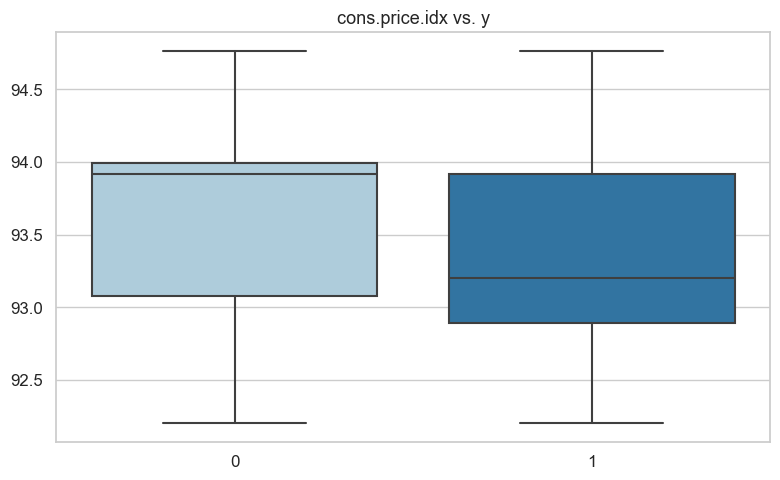

In [52]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=bank, x='y', y='cons.price.idx', palette='Paired')
plt.title('cons.price.idx vs. y', fontsize=13)
plt.xlabel(None)
plt.ylabel(None)
plt.tight_layout()
plt.show()

<u>_Phân tích:_</u>  

**Nhóm y=0 (không đăng ký):**
- Median nằm **quanh 94.0**.
- Khoảng giá trị khá rộng, thiên về phía CPI cao.
- Điều này cho thấy nhiều khách hàng từ chối đăng ký khi chỉ số giá tiêu dùng cao hơn, tức là khi lạm phát cao.

**Nhóm y=1 (đăng ký):**
- Median nằm ở **khoảng 93.1**, thấp hơn đáng kể so với nhóm từ chối.
- Các giá trị phân phối dồn về phía CPI thấp, tức là thời kỳ giá cả tương đối ổn định.

**Khách hàng đăng ký tiền gửi kỳ hạn nhiều hơn khi CPI giảm:**
- Chỉ số cons.price.idx càng cao => giá cả thị trường tăng => giảm sức mua và tăng chi phí sinh hoạt.
- Trong môi trường lạm phát cao, khách hàng có thể:
    - Trì hoãn quyết định tài chính dài hạn.
    - Ưu tiên thanh khoản thay vì "khoá tiền" trong tài khoản kì hạn.
- Ngược lại, khi CPI thấp, chi phí cơ hội của việc gửi tiền thấp hơn, khách hàng dễ quyết định tiết kiệm dài hạn hơn.
- Khách hàng có xu hướng đăng ký tiền gửi kỳ hạn nhiều hơn trong thời kỳ giá ổn định hoặc giảm (CPI thấp).

#### **4.3. CONS.CONF.IDX column**
- Chỉ số niềm tin tiêu dùng (hàng tháng)

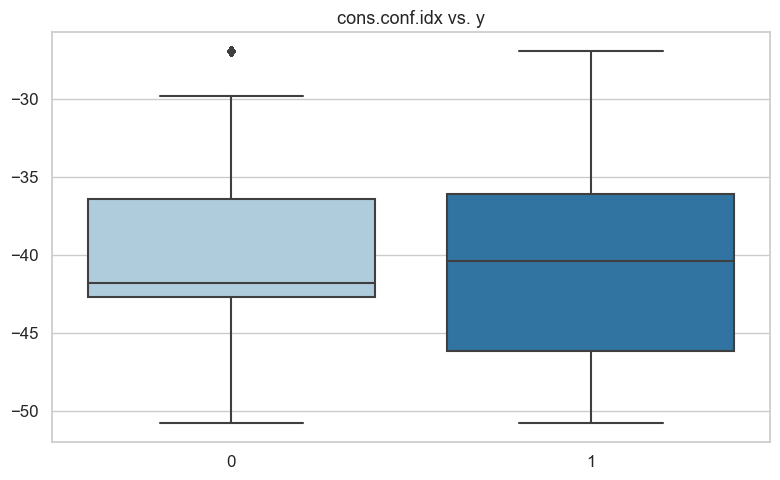

In [53]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=bank, x='y', y='cons.conf.idx', palette='Paired')
plt.title('cons.conf.idx vs. y', fontsize=13)
plt.xlabel(None)
plt.ylabel(None)
plt.tight_layout()
plt.show()

#### **4.4. EURIBOR3M column**
- Lãi suất euribor kỳ hạn 3 tháng, được cập nhật theo tần suất hàng ngày.
- Euribor (Euro Interbank Offered Rate) là lãi suất tham chiếu mà các ngân hàng trong khu vực đồng Euro sẵn sàng cho nhau vay mượn mà không có tài sản đảm bảo. Mức lãi suất 3 tháng là một trong những kỳ hạn phổ biến nhất, thường được sử dụng để định giá các sản phẩm tài chính như **vay tiêu dùng, thế chấp, tiền gửi** và **trái phiếu ngắn hạn**.

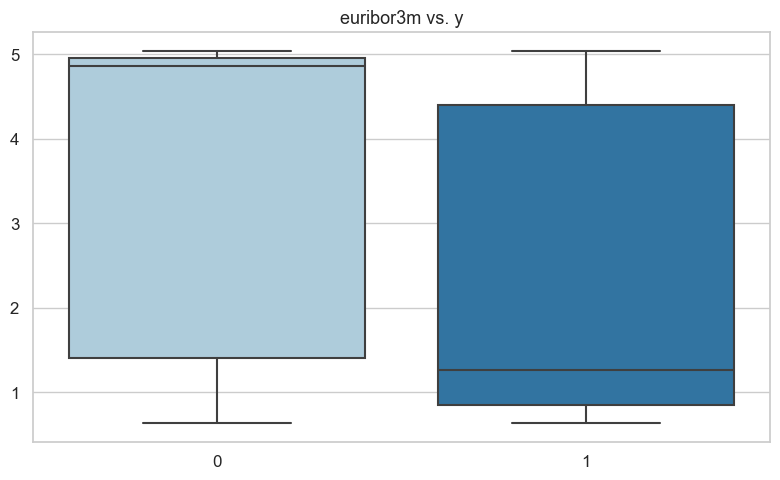

In [54]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=bank, x='y', y='euribor3m', palette='Paired')
plt.title('euribor3m vs. y', fontsize=13)
plt.xlabel(None)
plt.ylabel(None)
plt.tight_layout()
plt.show()

<u>_Phân tích:_</u>  

**Nhóm y=0 (không đăng ký):**
- Median cao hơn, **gần mức 5.0**.
- Phân phối khá hẹp ở phía cao, đa số khách hàng không đăng ký trong bối cảnh lãi suất cao.

**Nhóm y=1 (đăng ký):**
- Median thấp hơn, **khoảng 1.2-1.3**.
- Dải phân phối rộng hơn, kéo dài xuống vùng lãi suất rất thấp.

**Giải thích hành vi tài chính:**
- Thông thường, lãi suất cao sẽ khuyến khích tiết kiệm vì người dân sẽ được hưởng lợi nhiều hơn từ việc gửi tiền.
- Tuy nhiên, trong bộ dữ liệu này, hành vi lại ngược lại, và có thể được lý giải bằng các yếu tố sau:
    - Chiến dịch telemarketing mạnh hơn khi lãi suất thấp. Trong giai đoạn Euribor thấp, ngân hàng cần huy động vốn => tăng cường chiến dịch gọi điện, khuyến mại => dẫn đến nhiều khách hàng tiếp cận và đồng ý đăng ký.
    - Lãi suất thấp thường đi kèm với bối cảnh kinh tế bất ổn => người tiêu dùng ưu tiên an toàn tài chính và gửi tiết kiệm kỳ hạn là phương án hợp lý với họ.
    - Dữ liệu không phản ánh hành vi chủ động của khách hàng, mà phản ánh mức độ thành công của chiến dịch marketing trong bối cảnh lãi suất thấp.

#### **4.5. NR.EMPLOYED column**
- Số lượng người lao động

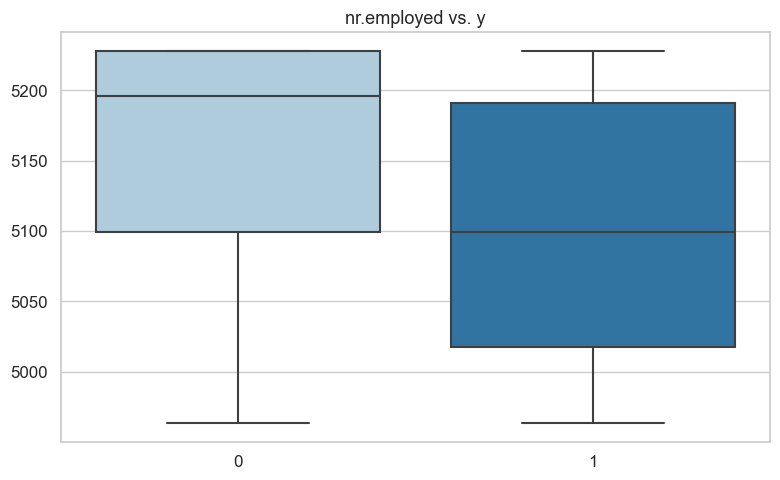

In [55]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=bank, x='y', y='nr.employed', palette='Paired')
plt.title('nr.employed vs. y', fontsize=13)
plt.xlabel(None)
plt.ylabel(None)
plt.tight_layout()
plt.show()

### **5. Visualization (summary)**

In [134]:
categorical_columnss = ['contact', 'marital', 'poutcome', 'job', 'education', 'month']

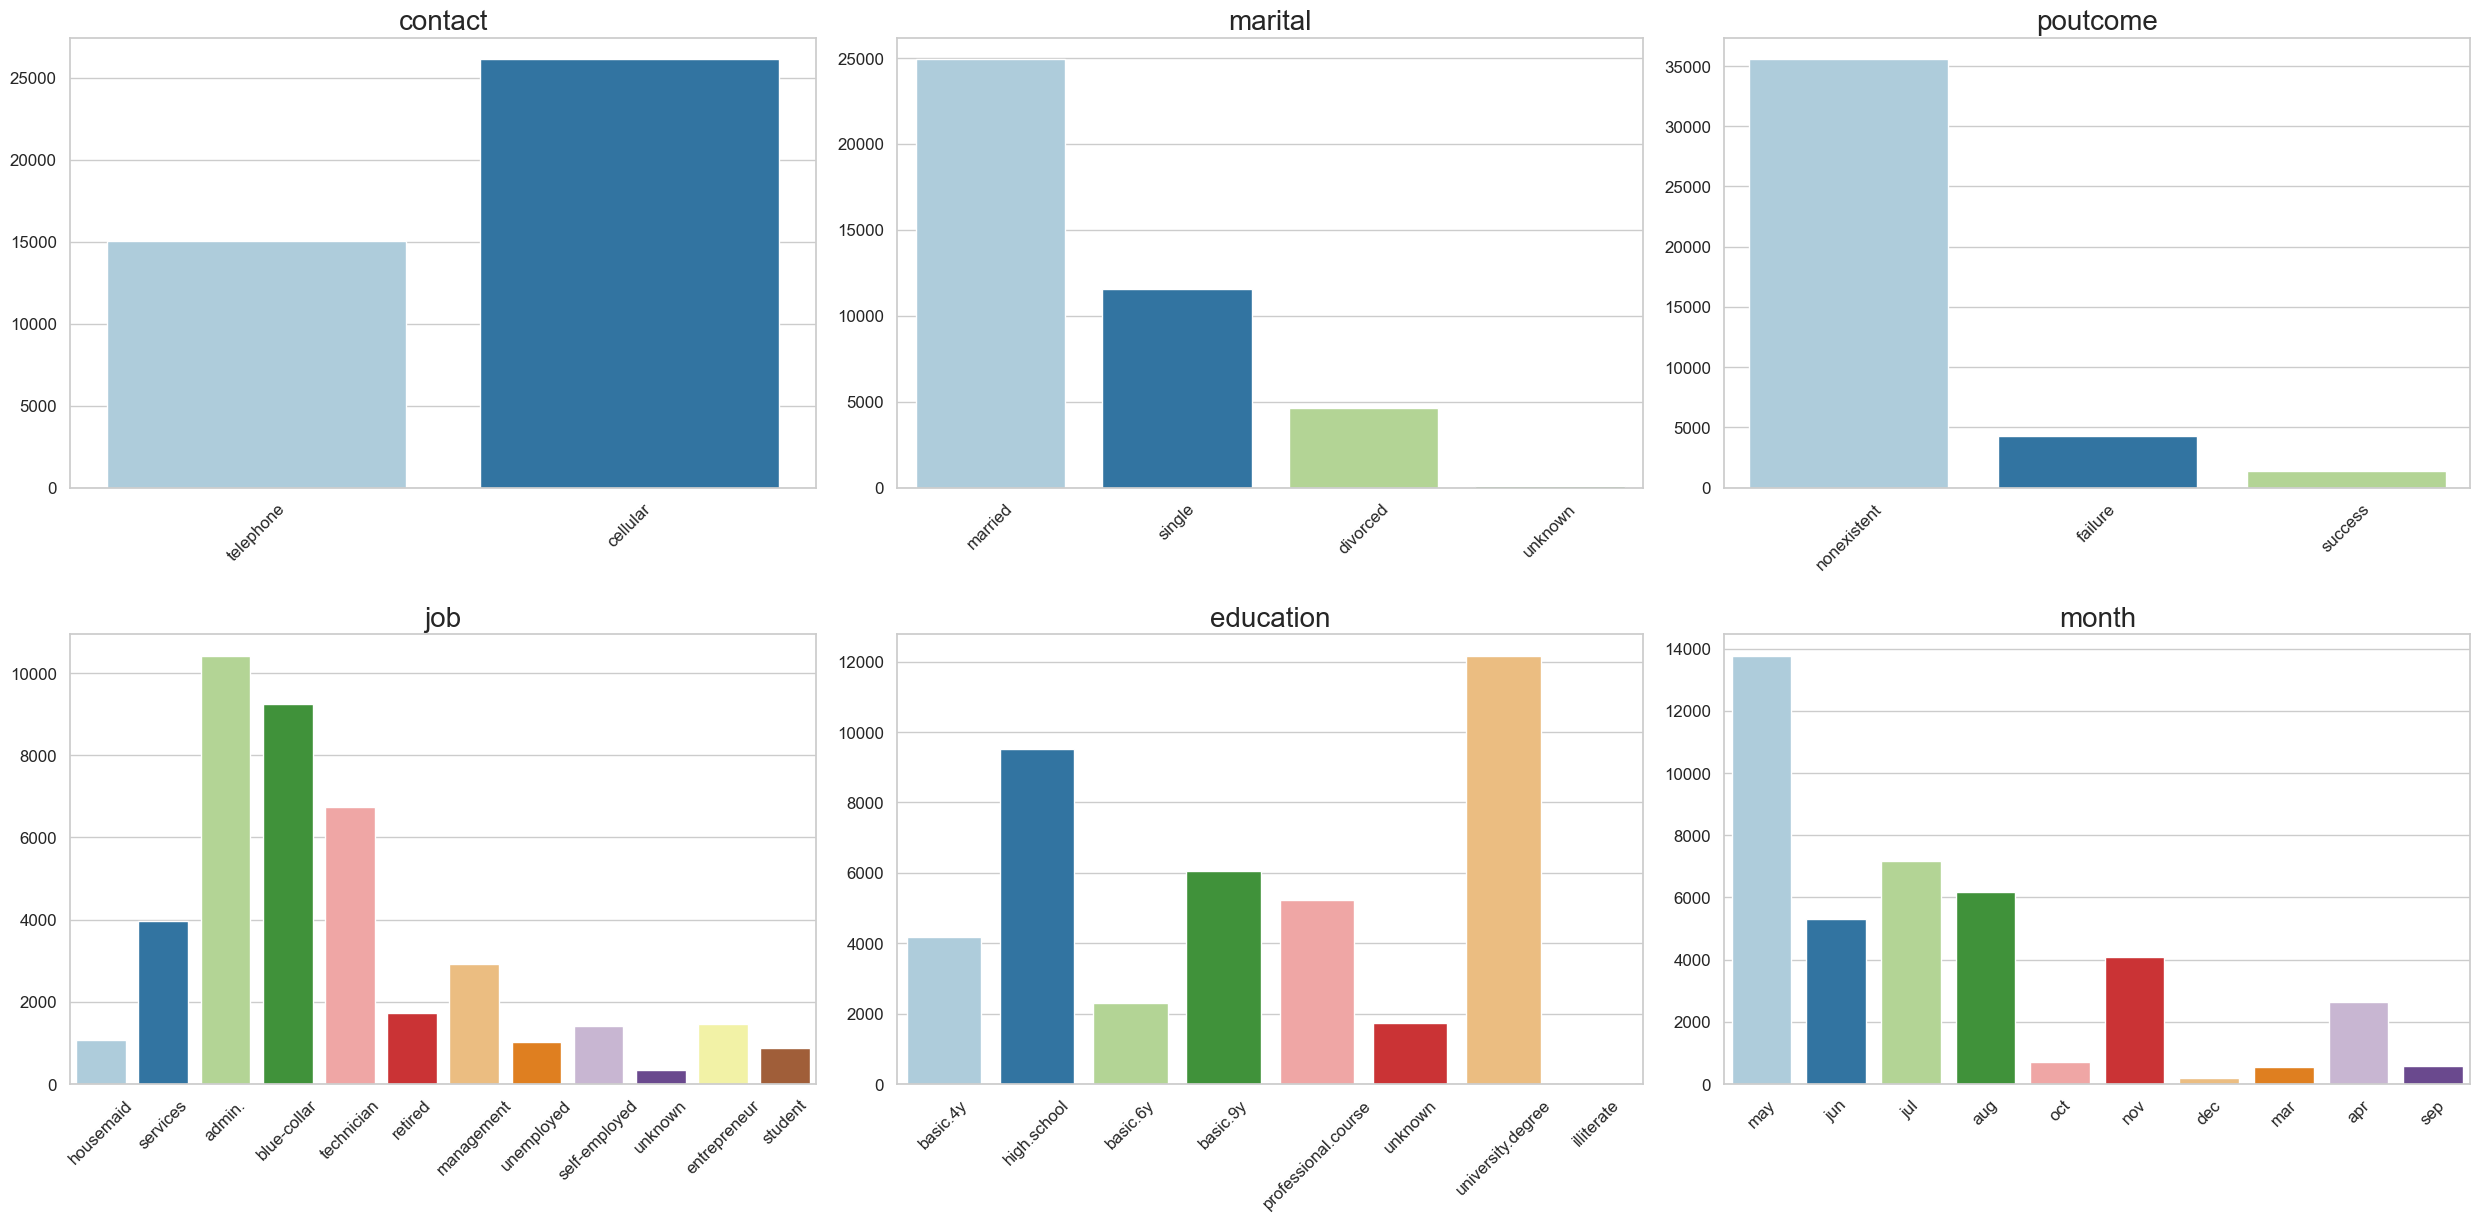

In [143]:
# categorical columns
plt.figure(figsize=(25, 35))
for i, column in enumerate(categorical_columnss[:], 1):
    plt.subplot(6, 3, i)
    sns.countplot(data=bank, x=column, palette='Paired')
    plt.title(column, fontsize=20)
    plt.xlabel(None)
    plt.ylabel(None)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

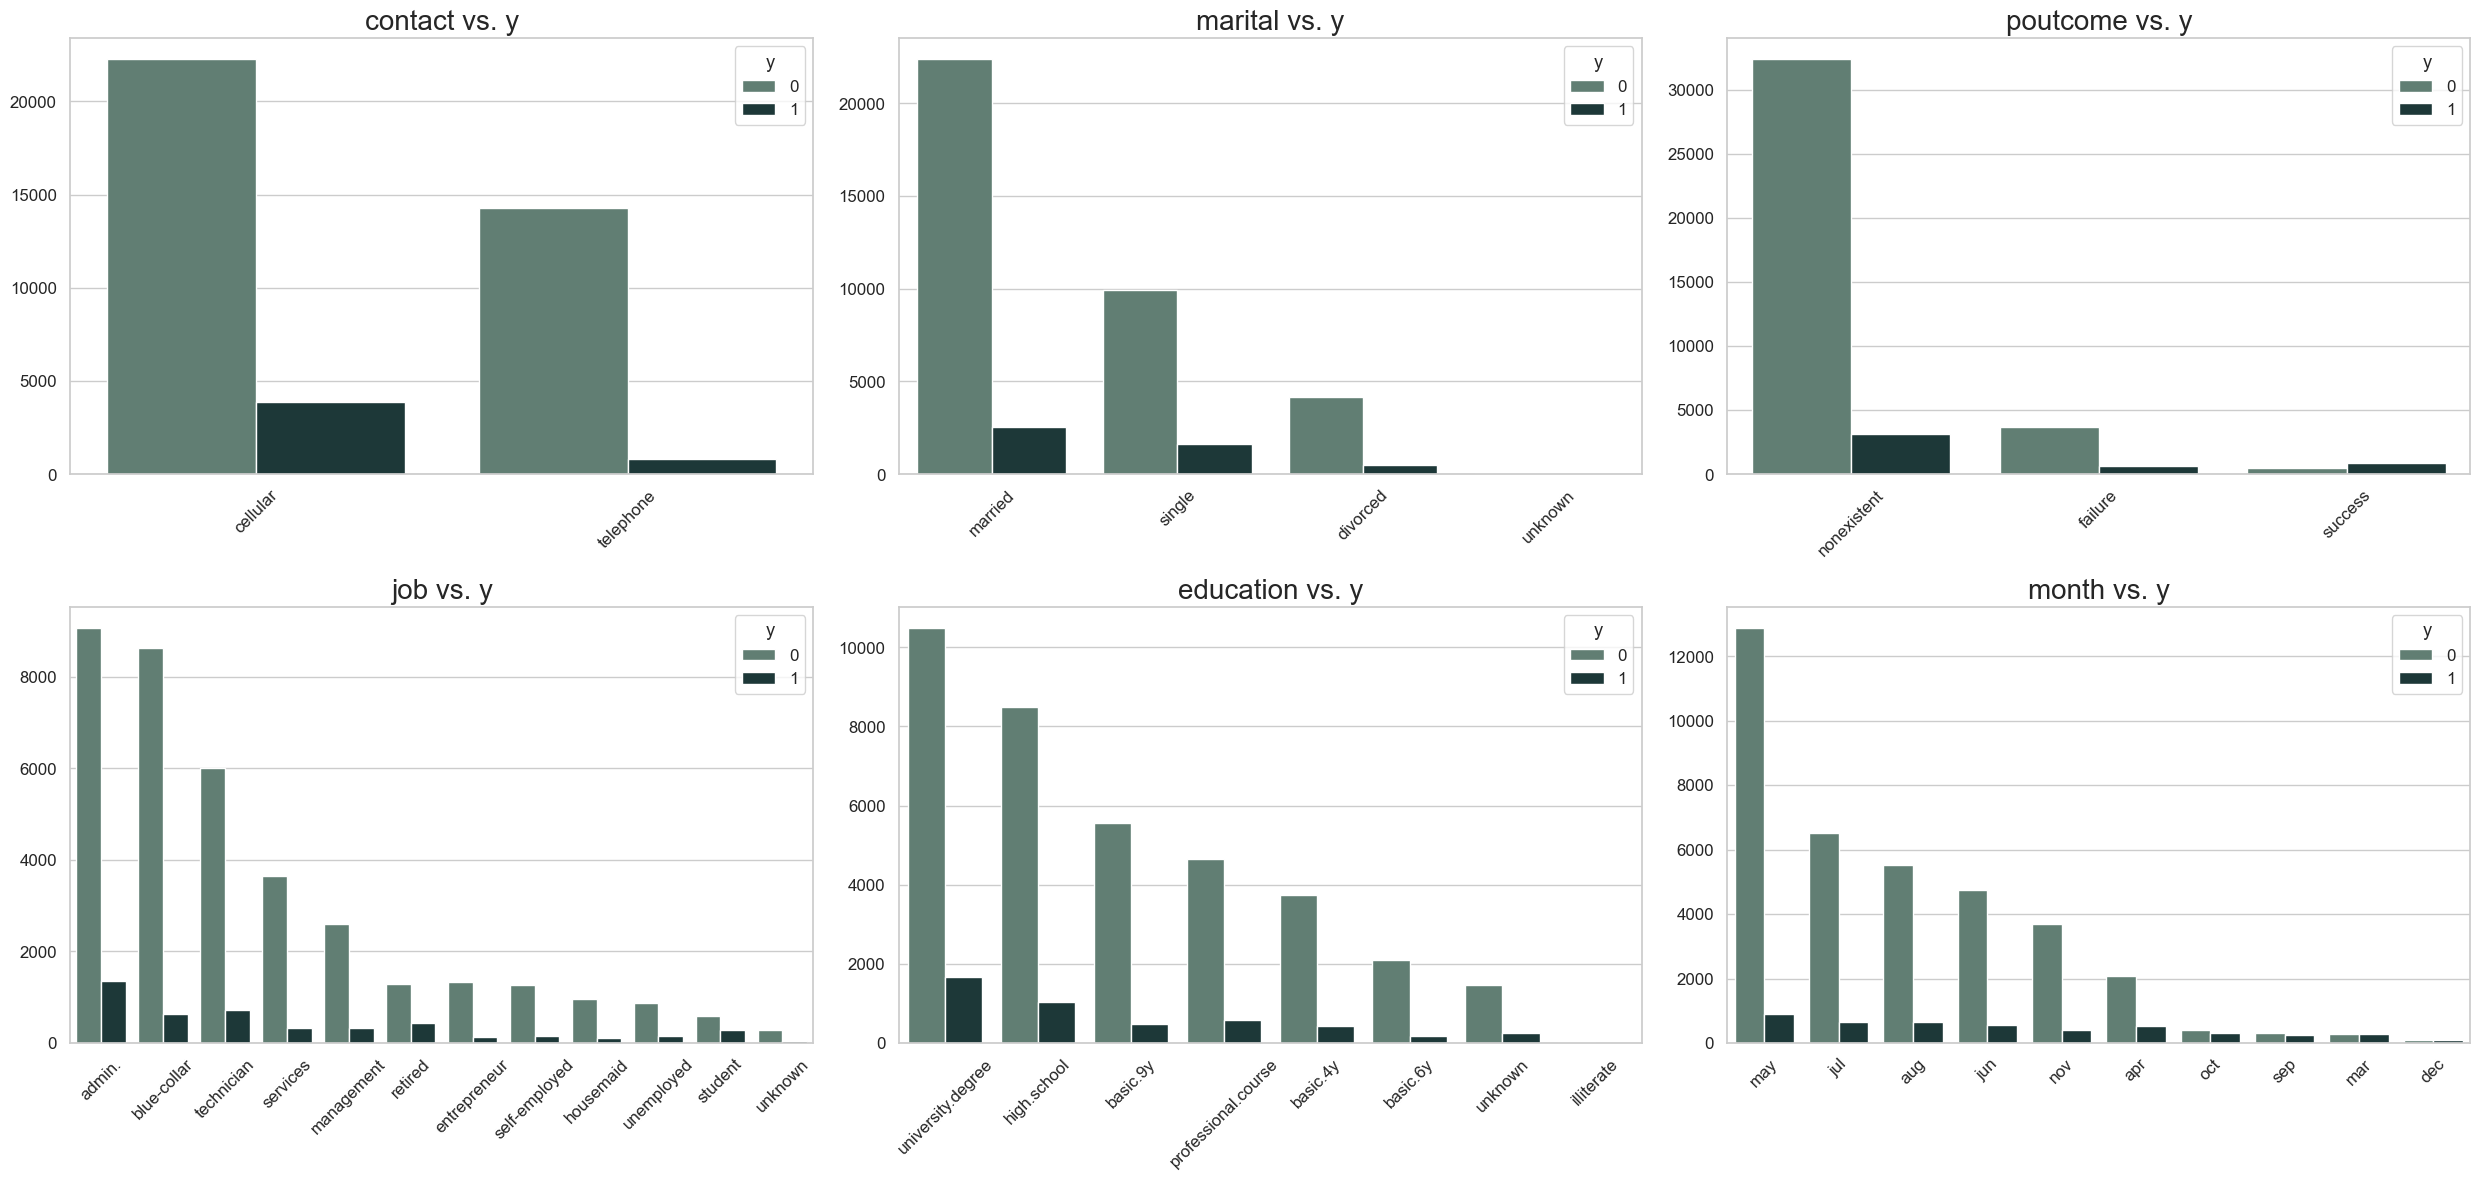

In [151]:
# Bivariable check (categorical vs. y, sorted by frequency)
palette = {'0': '#5C8374', '1': '#183D3D'}  # Dark green & pastel green

for col in categorical_columns:
    bank[col] = bank[col].astype(str)

plt.figure(figsize=(25,12))

for i, column in enumerate(categorical_columnss[:], 1):
    plt.subplot(2, 3, i)

    order = bank[column].value_counts().index
    sns.countplot(data=bank, x=column, hue='y', order=order, palette=palette)
    plt.title(f'{column} vs. y', fontsize=20)
    plt.xlabel(None)
    plt.ylabel(None)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [84]:
bank['housing'].value_counts()

housing
yes        21571
no         18615
unknown      990
Name: count, dtype: int64

### **6. Correlation**

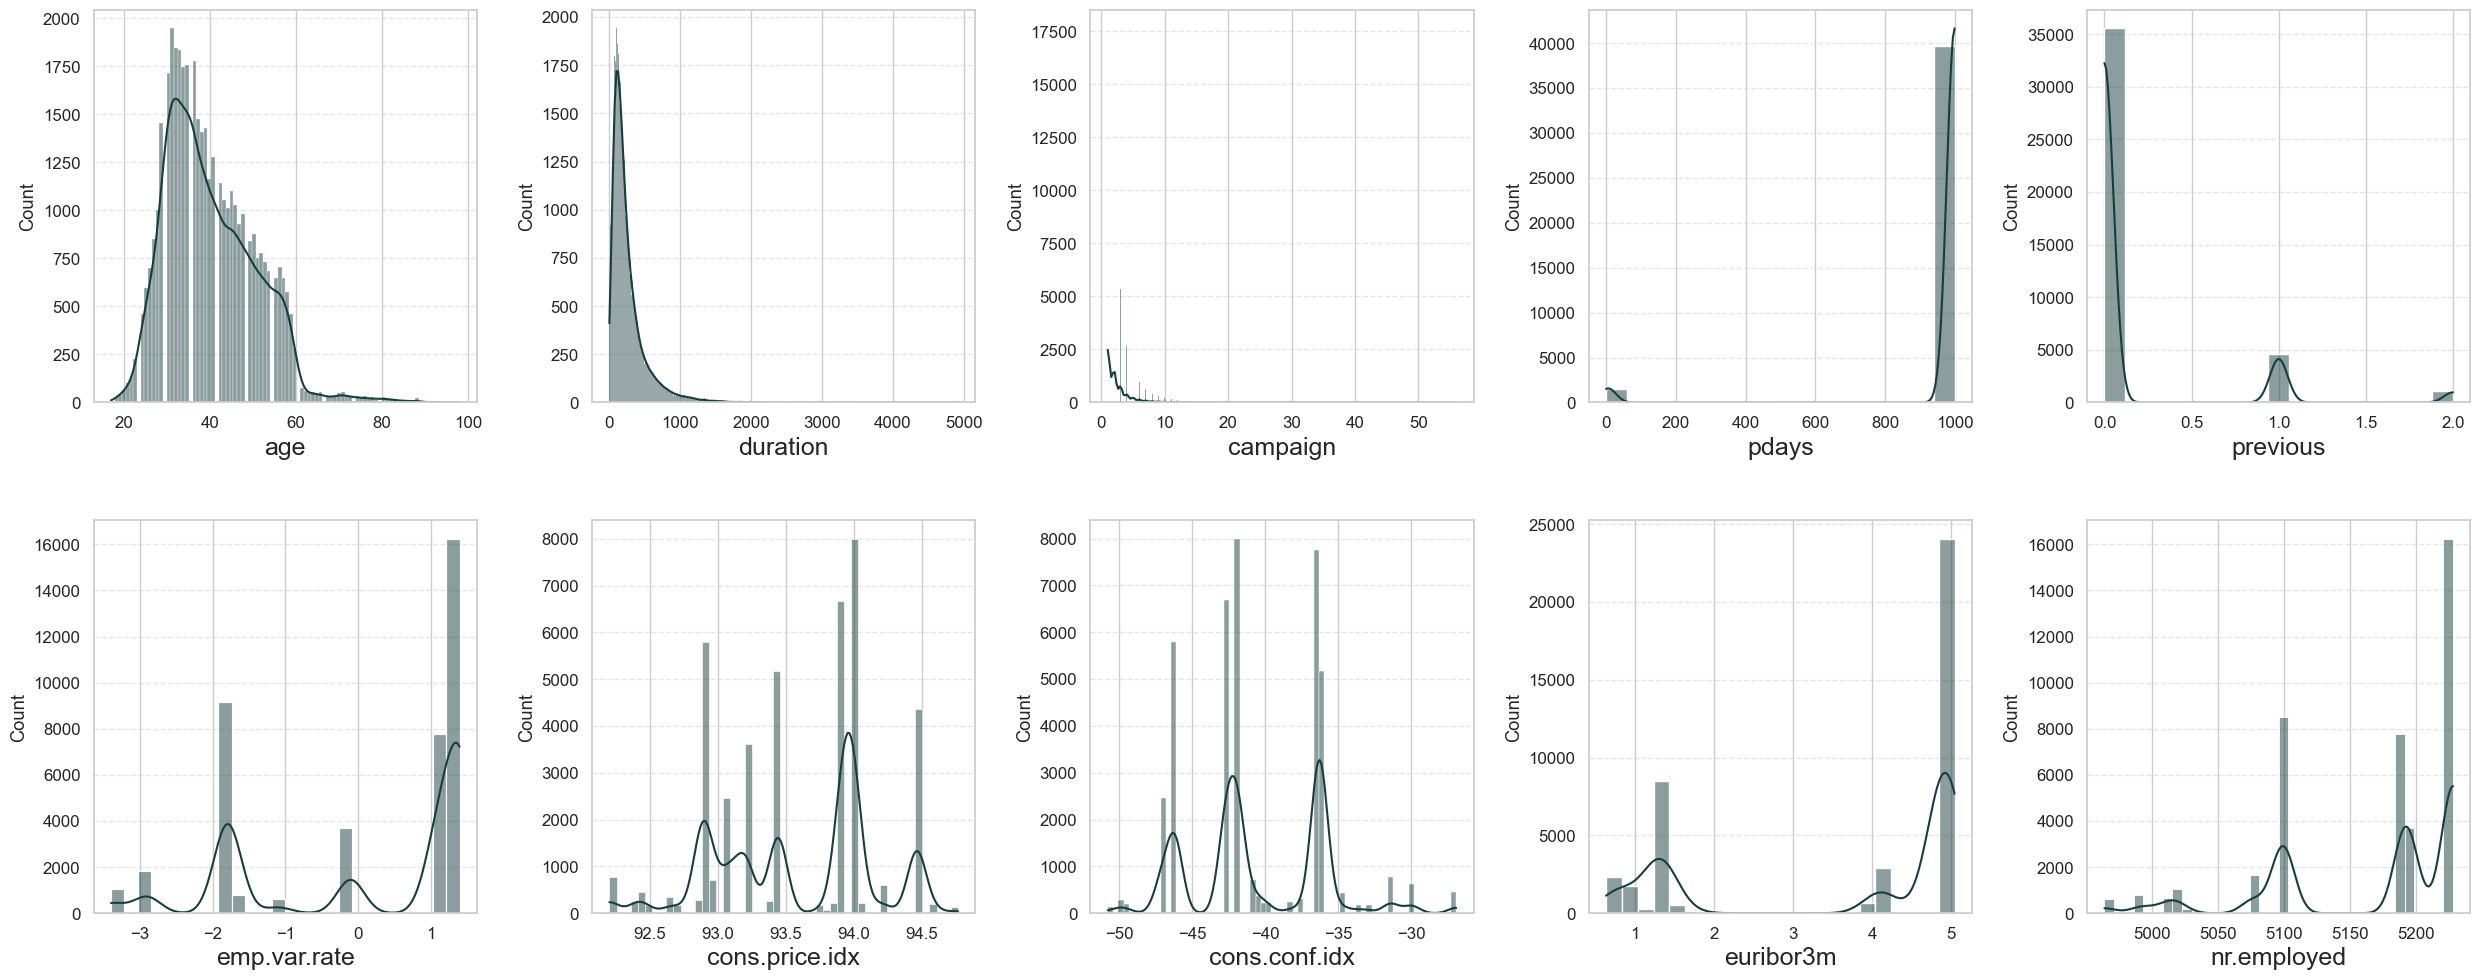

In [105]:
plt.figure(figsize=(25, 10))
plt.rcParams['axes.facecolor'] = 'white'

# Lấy danh sách biến số
num_cols = bank.drop(columns=['y']).select_dtypes(include=['int', 'float']).columns
for i, col in enumerate(num_cols):
    ax = plt.subplot(2, 5, i + 1) 
    sns.histplot(data=bank, x=col, kde=True, color='#183D3D', ax=ax)
    ax.set_facecolor('white')     
    ax.grid(axis='y', linestyle='--', alpha=0.5) 
    ax.set_xlabel(col, fontsize=18)  # 👈 Thêm dòng này để chỉnh font size


# plt.suptitle('Distribution of Continuous Variables', fontsize=18, y=1.02)
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.3)  
plt.show()


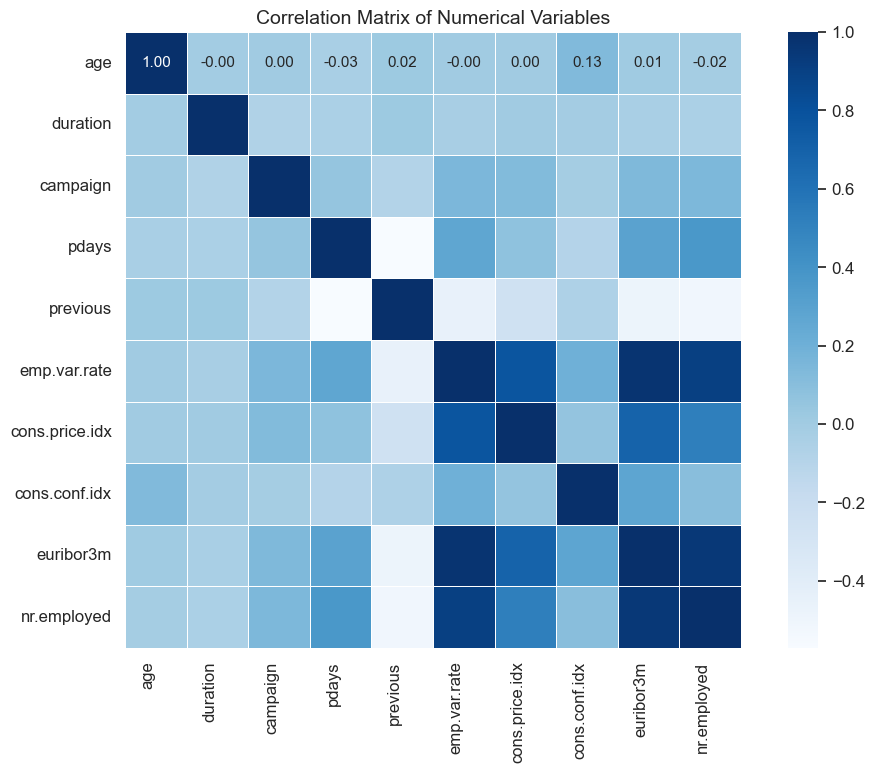

In [59]:
correlation_matrix = bank[numerical_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix,
    annot=True, cmap='Blues',
    linewidths=0.5, square=True, cbar=True,
    annot_kws={"size": 11}, fmt=".2f"
)

plt.xticks(rotation=90, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.title('Correlation Matrix of Numerical Variables', fontsize=14)
plt.show()

### **6. Outliers**

In [60]:
#check quartile của các cột numericals
for column in numerical_columns:
    print(f'For {column}:')

    print('Min:', bank[column].quantile(q = 0))
    print('1º Quartile:', bank[column].quantile(q = 0.25))
    print('2º Quartile:', bank[column].quantile(q = 0.50))
    print('3º Quartile:', bank[column].quantile(q = 0.75))
    print('Max:', bank[column].quantile(q = 1.00),'\n')

For age:
Min: 17.0
1º Quartile: 32.0
2º Quartile: 38.0
3º Quartile: 47.0
Max: 98.0 

For duration:
Min: 0.0
1º Quartile: 102.0
2º Quartile: 180.0
3º Quartile: 319.0
Max: 4918.0 

For campaign:
Min: 1.0
1º Quartile: 1.0
2º Quartile: 2.0
3º Quartile: 3.0
Max: 56.0 

For pdays:
Min: 0.0
1º Quartile: 999.0
2º Quartile: 999.0
3º Quartile: 999.0
Max: 999.0 

For previous:
Min: 0.0
1º Quartile: 0.0
2º Quartile: 0.0
3º Quartile: 0.0
Max: 2.0 

For emp.var.rate:
Min: -3.4
1º Quartile: -1.8
2º Quartile: 1.1
3º Quartile: 1.4
Max: 1.4 

For cons.price.idx:
Min: 92.201
1º Quartile: 93.075
2º Quartile: 93.749
3º Quartile: 93.994
Max: 94.767 

For cons.conf.idx:
Min: -50.8
1º Quartile: -42.7
2º Quartile: -41.8
3º Quartile: -36.4
Max: -26.9 

For euribor3m:
Min: 0.634
1º Quartile: 1.344
2º Quartile: 4.857
3º Quartile: 4.961
Max: 5.045 

For nr.employed:
Min: 4963.6
1º Quartile: 5099.1
2º Quartile: 5191.0
3º Quartile: 5228.1
Max: 5228.1 



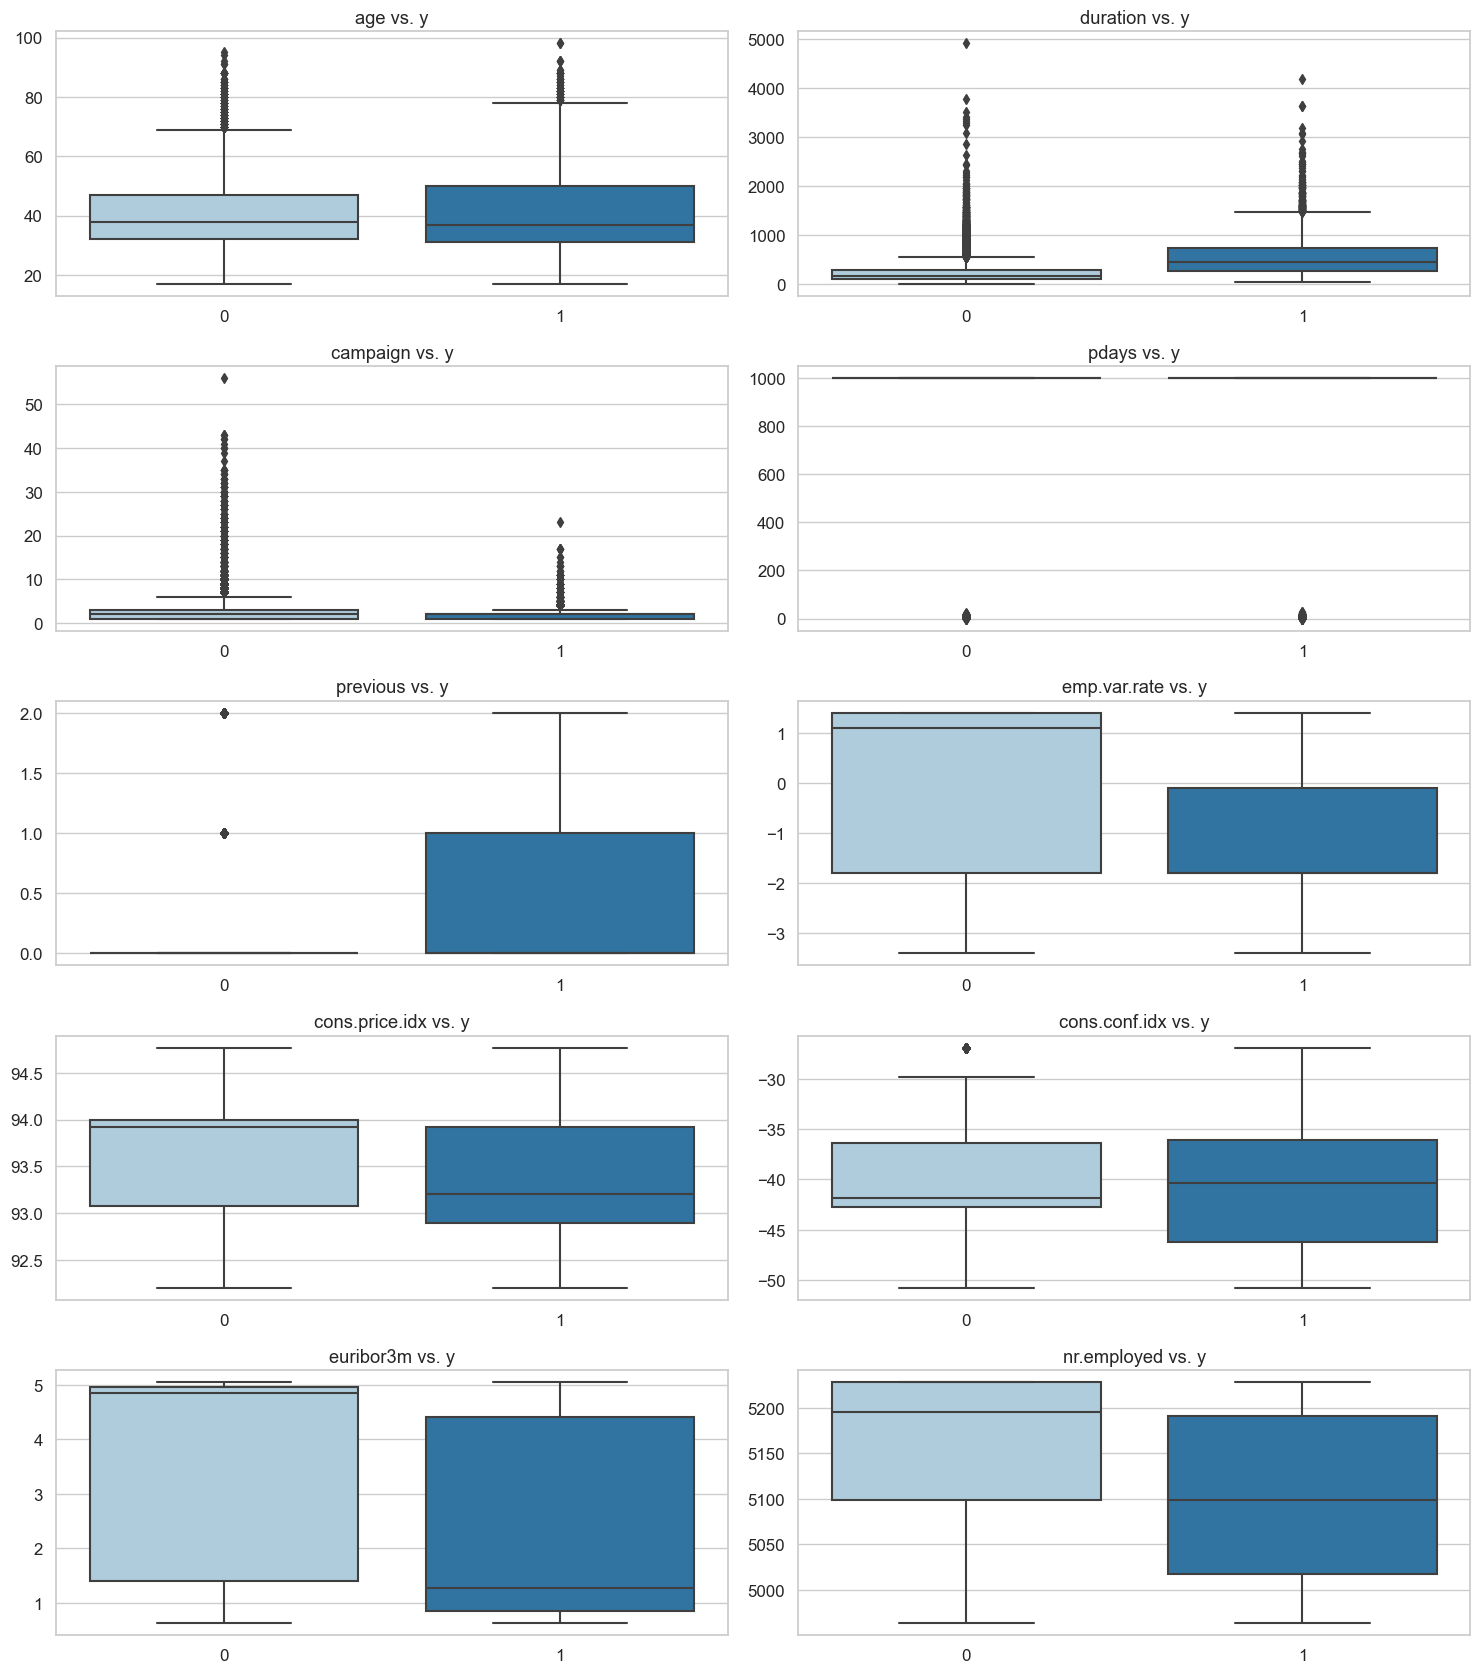

In [61]:
numerical_cols = bank.select_dtypes(include='number').columns
numerical_cols = [col for col in numerical_columns if col != 'y']  # trừ cột y

sns.set_style("whitegrid")
plt.figure(figsize=(15, 20))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(6, 2, i)
    sns.boxplot(data=bank, x='y', y=column, palette='Paired')
    plt.title(f'{column} vs. y')
    plt.xlabel(None)
    plt.ylabel(None)

plt.tight_layout()
plt.show()

### **7. Class distribution**

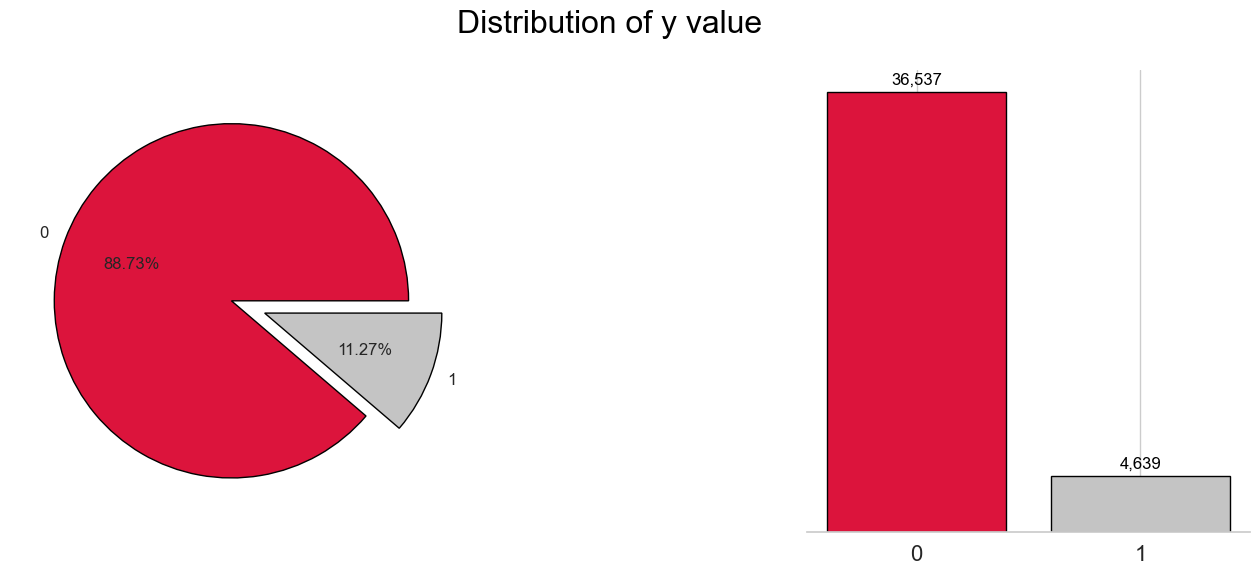

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_distribution(bank, 'y', ax)
plt.show()

<u>_Take note:_</u>  

**Oversampling (tăng lớp thiểu số):**
- SMOTE: tạo ra các mẫu data giả lập cho lớp thiểu số bằng cách nội suy giữa các điểm gần nhau
- adaptive syntheticc sampling
- random oversampling: nhân bản ngẫu nhiên các quan sát từ lớp thiểu số

**Undersampling (giảm lớp đa số):**
- random undersampling
- tomek links
- nearmiss: chọn các mẫu lớp đa số gần với lớp thiểu số để giữ lại

**Khi nào dùng:**
- Oversampling: phù hợp khi dữ liệu ít, cần dữ lại nhiều thông tin
- Undersampling: phù hợp khi dữ liệu lớn, giảm bớt thời gian train data

**CONS of SMOTE:**
- SMOTE có thể tạo ra các điểm không thực tế nếu các điểm của lớp thiểu số phân bố không đều hoặc chồng lấn với lớp đa số.

### **8. Using T-SNE**

In [63]:
data = bank.copy()
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


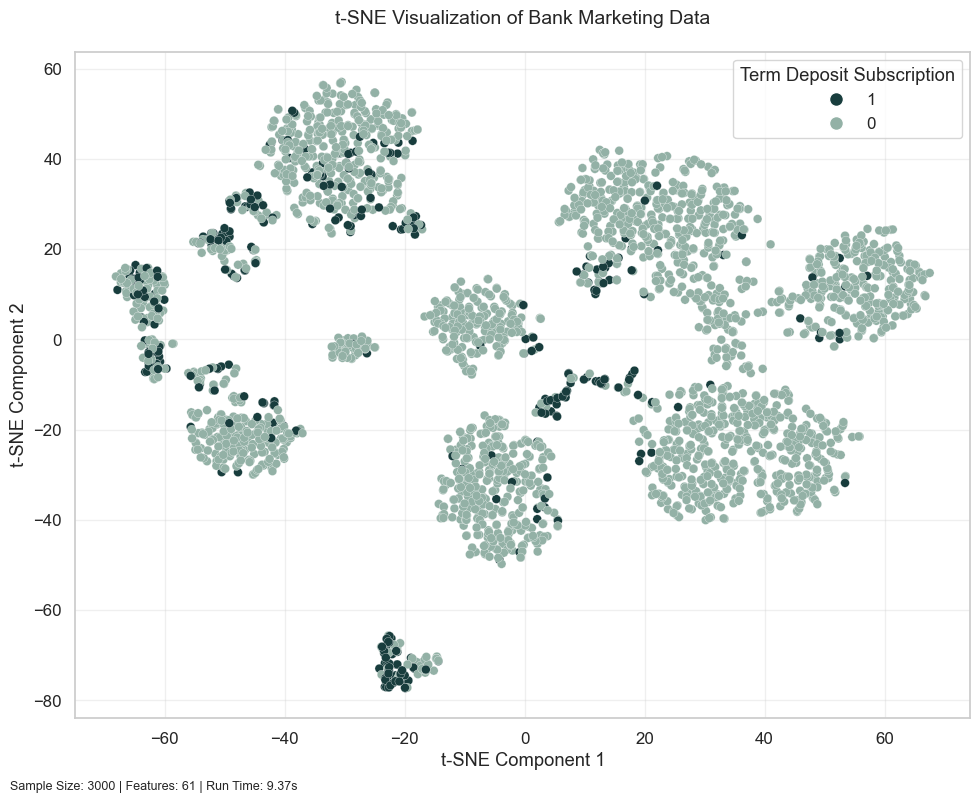

In [67]:
from sklearn.manifold import TSNE
import time

np.random.seed(42)

sample_size = min(3000, len(data))
data_sample = data.sample(sample_size, random_state=42)


categorical_cols = [col for col in ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome'] if col in data_sample.columns]
numerical_cols = [col for col in ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'] if col in data_sample.columns]

# 3. Lưu nhãn
y_sample = data_sample['y']
unique_y_values = y_sample.unique()

# 4. Gán màu cho từng class
colors_available = ['#183D3D', '#93B1A6']
color_map = {val: colors_available[i % len(colors_available)] for i, val in enumerate(unique_y_values)}

# 5. Tiền xử lý dữ liệu
data_encoded = pd.get_dummies(data_sample, columns=categorical_cols)

if numerical_cols:
    scaler = StandardScaler()
    data_encoded[numerical_cols] = scaler.fit_transform(data_encoded[numerical_cols])

X = data_encoded.drop('y', axis=1)

# 6. Chạy t-SNE
start_time = time.time()

tsne = TSNE(
    n_components=2,
    perplexity=min(30, sample_size//5),
    learning_rate=200,
    n_iter=1000,
    method='barnes_hut',
    random_state=42,
    verbose=0
)

X_tsne = tsne.fit_transform(X)
end_time = time.time()

# 7. Vẽ biểu đồ
plt.figure(figsize=(10, 8))
colors = y_sample.map(color_map)

plt.scatter(
    X_tsne[:, 0], 
    X_tsne[:, 1], 
    c=colors,
    s=40, 
    alpha=1,
    edgecolor='w',
    linewidth=0.2
)

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor=color_map[label], 
                              markersize=10, label=f"{label}") 
                   for label in unique_y_values]

legend = plt.legend(handles=legend_elements, title="Term Deposit Subscription", loc="best")
# legend.get_title().set_fontweight('bold')

plt.title("t-SNE Visualization of Bank Marketing Data", fontsize=14, pad=20)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(alpha=0.3)
plt.tight_layout()

# Thông tin phụ
plt.figtext(0.02, 0, 
            f"Sample Size: {sample_size} | Features: {X.shape[1]} | Run Time: {end_time - start_time:.2f}s", 
            fontsize=9, ha='left')

plt.show()

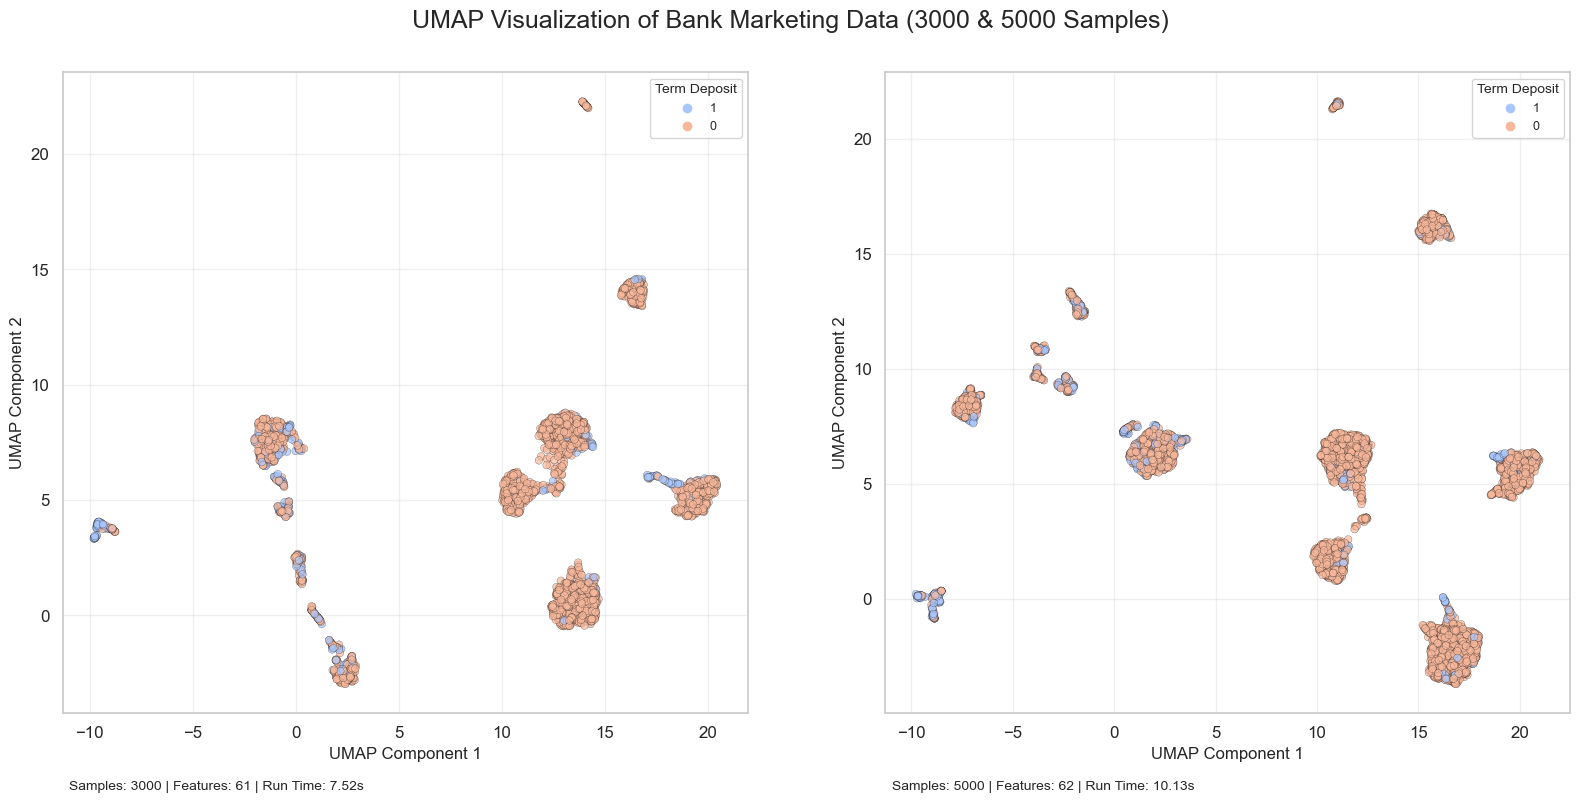

In [65]:
import umap
import time

# Set seed
np.random.seed(42)

# Hàm để chạy UMAP và trả kết quả
def plot_umap(data, sample_size, ax):
    # Lấy mẫu dữ liệu
    sample_size = min(sample_size, len(data))
    data_sample = data.sample(sample_size, random_state=42)

    # Cột phân loại và số
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
                        'contact', 'month', 'day_of_week', 'poutcome']
    numerical_cols = ['age', 'duration', 'campaign', 'pdays', 'previous', 
                      'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

    y_sample = data_sample['y']
    data_encoded = pd.get_dummies(data_sample, columns=[col for col in categorical_cols if col in data_sample.columns])

    scaler = StandardScaler()
    data_encoded[numerical_cols] = scaler.fit_transform(data_encoded[numerical_cols])

    X = data_encoded.drop('y', axis=1)

    # UMAP Embedding
    start_time = time.time()
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.1,
        metric='euclidean',
        random_state=42
    )
    X_umap = reducer.fit_transform(X)
    end_time = time.time()

    # Vẽ scatterplot
    sns.scatterplot(
        x=X_umap[:, 0],
        y=X_umap[:, 1],
        hue=y_sample,
        palette="coolwarm",
        s=30,
        alpha=0.7,
        edgecolor='black',
        linewidth=0.2,
        ax=ax
    )

    ax.set_xlabel("UMAP Component 1", fontsize=12)
    ax.set_ylabel("UMAP Component 2", fontsize=12)
    ax.legend(title="Term Deposit", fontsize=9, title_fontsize=10, loc="best")
    ax.grid(alpha=0.3)

    ax.text(0.01, -0.12, 
            f"Samples: {sample_size} | Features: {X.shape[1]} | Run Time: {end_time - start_time:.2f}s",
            fontsize=10,
            transform=ax.transAxes,
            ha='left')


fig, axs = plt.subplots(1, 2, figsize=(16, 8))
plot_umap(data, sample_size=3000, ax=axs[0])
plot_umap(data, sample_size=5000, ax=axs[1])

plt.suptitle("UMAP Visualization of Bank Marketing Data (3000 & 5000 Samples)", fontsize=18, y=1)
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.show()
